In [1]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pycountry
import zipfile
import math

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam, SGD
from sklearn.linear_model import LinearRegression

In [3]:
# Importing data
main_df = pd.read_excel("Data/organizedviolencecy_v23_2.xlsx")

# List of country codes to keep (recognized country)
recognized_country_codes = [
    "AFG", "ALA", "ALB", "DZA", "ASM", "AND", "AGO", "AIA", "ATA", "ATG", "ARG", "ARM", "ABW", "AUS", "AUT", "AZE",
    "BHS", "BHR", "BGD", "BRB", "BLR", "BEL", "BLZ", "BEN", "BMU", "BTN", "BOL", "BES", "BIH", "BWA", "BVT", "BRA",
    "IOT", "BRN", "BGR", "BFA", "BDI", "CPV", "KHM", "CMR", "CAN", "CYM", "CAF", "TCD", "CHL", "CHN", "CXR", "CCK",
    "COL", "COM", "COG", "COD", "COK", "CRI", "CIV", "HRV", "CUB", "CUW", "CYP", "CZE", "DNK", "DJI", "DMA", "DOM",
    "ECU", "EGY", "SLV", "GNQ", "ERI", "EST", "SWZ", "ETH", "FLK", "FRO", "FJI", "FIN", "FRA", "GUF", "PYF", "ATF",
    "GAB", "GMB", "GEO", "DEU", "GHA", "GIB", "GRC", "GRL", "GRD", "GLP", "GUM", "GTM", "GGY", "GIN", "GNB", "GUY",
    "HTI", "HMD", "VAT", "HND", "HKG", "HUN", "ISL", "IND", "IDN", "IRN", "IRQ", "IRL", "IMN", "ISR", "ITA", "JAM",
    "JPN", "JEY", "JOR", "KAZ", "KEN", "KIR", "PRK", "KOR", "KWT", "KGZ", "LAO", "LVA", "LBN", "LSO", "LBR", "LBY",
    "LIE", "LTU", "LUX", "MAC", "MDG", "MWI", "MYS", "MDV", "MLI", "MLT", "MHL", "MTQ", "MRT", "MUS", "MYT", "MEX",
    "FSM", "MDA", "MCO", "MNG", "MNE", "MSR", "MAR", "MOZ", "MMR", "NAM", "NRU", "NPL", "NLD", "NCL", "NZL", "NIC",
    "NER", "NGA", "NIU", "NFK", "MKD", "MNP", "NOR", "OMN", "PAK", "PLW", "PSE", "PAN", "PNG", "PRY", "PER", "PHL",
    "PCN", "POL", "PRT", "PRI", "QAT", "REU", "ROU", "RUS", "RWA", "BLM", "SHN", "KNA", "LCA", "MAF", "SPM", "VCT",
    "WSM", "SMR", "STP", "SAU", "SEN", "SRB", "SYC", "SLE", "SGP", "SXM", "SVK", "SVN", "SLB", "SOM", "ZAF", "SGS",
    "SSD", "ESP", "LKA", "SDN", "SUR", "SJM", "SWE", "CHE", "SYR", "TWN", "TJK", "TZA", "THA", "TLS", "TGO", "TKL",
    "TON", "TTO", "TUN", "TUR", "TKM", "TCA", "TUV", "UGA", "UKR", "ARE", "GBR", "USA", "UMI", "URY", "UZB", "VUT",
    "VEN", "VNM", "VGB", "VIR", "WLF", "ESH", "YEM", "ZMB", "ZWE"
]


In [4]:


# Create dictionaries to map country names to ISO codes and vice versa
country_name_to_iso = {country.name: country.alpha_3 for country in pycountry.countries}
iso_to_country_name = {country.alpha_3: country.name for country in pycountry.countries}

# Create DataFrames from the dictionaries
df_country_name_to_iso = pd.DataFrame(list(country_name_to_iso.items()), columns=['Country Name', 'ISO_Code'])
df_iso_to_country_name = pd.DataFrame(list(iso_to_country_name.items()), columns=['ISO_Code', 'Country Name'])

# Merge the DataFrames into a single DataFrame without duplicating "Country Name"
iso_df = pd.merge(df_country_name_to_iso, df_iso_to_country_name, on='ISO_Code', how='inner', suffixes=('_country', '_iso'))

# Rename the "Country Name" column to "Name"
iso_df.rename(columns={'Country Name_country': 'Name', 'ISO_Code': 'stateid'}, inplace=True)

# Drop the duplicate "Country Name_iso" column
iso_df.drop(columns=['Country Name_iso'], inplace=True)

# Only keep the countries in the recognized_country_codes list
iso_df = iso_df[iso_df['stateid'].isin(recognized_country_codes)]



In [5]:
# Cleaning of GDP dataset: GDP between 1989 and 2022 in current US dollars
gdp_df = pd.read_csv("Data/gdp_world.csv", skiprows=4)



# Only keep relevant columns
gdp_df = gdp_df[["Country Name", "Country Code", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997",
                 "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010",
                 "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022"]]

# Only keep the countries recognized in the recognized_country_codes list
gdp_df = gdp_df[gdp_df["Country Code"].isin(recognized_country_codes)]

# Backfill NaN values
gdp_df = gdp_df.fillna(method='bfill', axis=1)

# rename Country Code to stateid
gdp_df = gdp_df.rename(columns={"Country Code": "stateid"})

# Frontfill NaN values -> some countries miss their 2022 value
gdp_df = gdp_df.fillna(method='ffill', axis=1)

# Replace country name next to stateid = COD to "DR Congo (Zaire)"
gdp_df.loc[gdp_df['stateid'] == 'COD', 'Country Name'] = "DR Congo (Zaire)"

# Initialize the mapping dictionary
name_mapping = {
    "Congo, Dem. Rep.": "Congo",
    "Tanzania": "Tanzania, United Republic of",
    "Turkiye": "Türkiye",
    "Moldova": "Moldova, Republic of",
    "Bahamas, The": "Bahamas",
    "Macao SAR, China": "China",
    "Korea, Rep.": "Korea, Republic of",
    "Curacao": "Curaçao",
    "Egypt, Arab Rep.": "Egypt",
    "Congo, Rep.": "Congo",
    "Bolivia": "Bolivia, Plurinational State of",
    "Virgin Islands (U.S.)": "Virgin Islands, U.S.",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "St. Martin (French part)": "Saint Martin (French part)",
    "Hong Kong SAR, China": "Hong Kong",
    "British Virgin Islands": "Virgin Islands, British",
    "Yemen, Rep.": "Yemen",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "Gambia, The": "Gambia",
}

# Manually update the mapping dictionary with the correct ISO names
name_mapping["Micronesia, Fed. Sts."] = "Micronesia, Federated States of"
name_mapping["Lao PDR"] = "Laos"
name_mapping["Iran, Islamic Rep."] = "Iran, Islamic Republic of"
name_mapping["Korea, Dem. People's Rep."] = "Korea, Democratic People's Republic of"
name_mapping["Kyrgyz Republic"] = "Kyrgyzstan"
name_mapping["St. Lucia"] = "Saint Lucia"
name_mapping["Slovak Republic"] = "Slovakia"

# Apply name mapping to GDP dataset
gdp_df['Country Name'] = gdp_df['Country Name'].map(name_mapping).fillna(gdp_df['Country Name'])

gdp_countries = gdp_df['Country Name'].unique()
iso_countries = iso_df['Name'].unique()

# Check if the same stateid is used for each country in both datasets
consistent_stateids = True
inconsistent_countries = []

for country in gdp_countries:
    if country in iso_countries:
        gdp_stateid = gdp_df.loc[gdp_df['Country Name'] == country, 'stateid'].iloc[0]
        iso_stateid = iso_df.loc[iso_df['Name'] == country, 'stateid'].iloc[0]
        
        if gdp_stateid != iso_stateid:
            consistent_stateids = False
            inconsistent_countries.append(country)

if consistent_stateids:
    print("The same stateid is used for each country in both datasets.")
else:
    print("The stateids are not consistent for the following countries:")
    print(inconsistent_countries)

# No data available for North Korea; estimation from tradingeconomics.com + linear interpolation

nk_gdp = {
    1989: 15770000000,
    1990: None,
    1991: None,
    1992: 11000000000,
    1993: None,
    1994: None,
    1995: 4850000000,
    1996: None,
    1997: None,
    1998: 11000000000,
    1999: None,
    2000: None,
    2001: None,
    2002: None,
    2003: None,
    2004: None,
    2005: None,
    2006: None,
    2007: None,
    2008: None,
    2009: None,
    2010: None,
    2011: None,
    2012: None,
    2013: None,
    2014: None,
    2015: None,
    2016: None,
    2017: None,
    2018: None,
    2019: None,
    2020: None,
    2021: None,
    2022: 20000000000
}

# Convert the dictionary to a DataFrame
nk_gdp_df = pd.DataFrame.from_dict(nk_gdp, orient='index', columns=['GDP'])

# Convert index to a column
nk_gdp_df.reset_index(inplace=True)
nk_gdp_df.rename(columns={'index': 'Year'}, inplace=True)

# Interpolate missing values linearly
nk_gdp_df['GDP'] = nk_gdp_df['GDP'].interpolate()

# Provided data
nk_gdp_values = {
    1989: 1.577000e+10, 1990: 1.418000e+10, 1991: 1.259000e+10, 1992: 1.100000e+10, 1993: 8.950000e+09,
    1994: 6.900000e+09, 1995: 4.850000e+09, 1996: 6.900000e+09, 1997: 8.950000e+09, 1998: 1.100000e+10,
    1999: 1.137500e+10, 2000: 1.175000e+10, 2001: 1.212500e+10, 2002: 1.250000e+10, 2003: 1.287500e+10,
    2004: 1.325000e+10, 2005: 1.362500e+10, 2006: 1.400000e+10, 2007: 1.437500e+10, 2008: 1.475000e+10,
    2009: 1.512500e+10, 2010: 1.550000e+10, 2011: 1.587500e+10, 2012: 1.625000e+10, 2013: 1.662500e+10,
    2014: 1.700000e+10, 2015: 1.737500e+10, 2016: 1.775000e+10, 2017: 1.812500e+10, 2018: 1.850000e+10,
    2019: 1.887500e+10, 2020: 1.925000e+10, 2021: 1.962500e+10, 2022: 2.000000e+10
}

# Locate the row with stateid equal to "PRK" in gdp_df
prk_row_index = gdp_df.index[gdp_df['stateid'] == 'PRK'].tolist()[0]

# Replace the values in columns 1989 to 2022 with the provided values
for year, gdp_value in nk_gdp_values.items():
    gdp_df.at[prk_row_index, str(year)] = gdp_value


# No data for Virgin Islands and Gibraltar: drop the columns (not used in main_df)
gdp_df = gdp_df[~gdp_df['stateid'].isin(['VGB', 'GIB'])]


The same stateid is used for each country in both datasets.


C:\Users\troen\AppData\Local\Temp\ipykernel_24080\4244091700.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_df = gdp_df.fillna(method='bfill', axis=1)
C:\Users\troen\AppData\Local\Temp\ipykernel_24080\4244091700.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_df = gdp_df.fillna(method='ffill', axis=1)


In [6]:
# Extracting from zip file
zip_file_path = "Data/EdStats_CSV.zip"

csv_file_name = 'EdStatsData.csv'

# Open the .zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the CSV file from the .zip archive
    with zip_ref.open(csv_file_name) as csv_file:
        # Read the CSV file using pandas
        education_df = pd.read_csv(csv_file)



# Only keep relevant columns, between 1989 and 2022
education_df = education_df[["Country Name", "Country Code", "Indicator Name" ,"Indicator Code", "1989", "1990", "1991", "1992", "1993", "1994", "1995",
                             "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006",
                             "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]]

# Delete rows where every year is NaN
education_df = education_df.dropna(how='all', subset=["1989", "1990", "1991", "1992", "1993", "1994", "1995",
                                                      "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003",
                                                      "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011",
                                                      "2012", "2013", "2014", "2015", "2016", "2017"])


# Drop all rows where indicator name = Population growth (annual %)
education_df = education_df[education_df["Indicator Name"] != "Population growth (annual %)"]


# Drop all columns where more than 35% of the values are NaN
education_df = education_df.dropna(thresh=0.35*len(education_df), axis=1)

# Drop 2003, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2015
education_df = education_df.drop(columns=["2003", "2006", "2007", "2008", "2009", "2011", "2012", "2013", "2015"])

# Drop rows where the value for 1995, 2000, 2005 and 2010 is NaN
education_df = education_df.dropna(subset=["1995", "2000", "2005", "2010"], how='all')

# Drop the rows where 2 or more value for 1995, 2000, 2005 and 2010 are NaN
education_df = education_df.dropna(subset=["1995", "2000", "2005", "2010"], thresh=2)

# Pivot the dataframe
education_df = education_df.pivot_table(index=['Country Name', 'Country Code'], columns='Indicator Name', values=['1995', '2000', '2005', '2010'])

# Reset index to make 'Country Name' and 'Country Code' regular columns
education_df.reset_index(inplace=True)

# Flatten column names
education_df.columns = [' '.join(col).strip() for col in education_df.columns.values]

# Drop columns where more than 50% of the values are NaN
education_df = education_df.dropna(thresh=0.5*len(education_df), axis=1)

# Drop all columns that contain the word "total"
education_df = education_df[education_df.columns.drop(list(education_df.filter(like='Total')))]


In [7]:
# Cleaning the main_df

# Remove columns with disagregated deaths. Only keep "prior" information and cumulative total deaths.
main_df = main_df.loc[:, ['country_id_cy', 'country_cy', 'year_cy', 'region_cy', 'sb_dyad_count_cy', 'sb_dyad_ids_cy',
                          'sb_intrastate_dyad_count_cy', 'sb_intrastate_main_govt_inv_incomp_cy',
                          'sb_interstate_dyad_count_cy',
                          'sb_interstate_main_govt_inv_incomp_cy', 'ns_dyad_count_cy', 'ns_dyad_ids_cy',
                          'os_dyad_count_cy', 'os_dyad_ids_cy', 'os_main_govt_inv_cy', 'os_any_govt_inv_cy',
                          'os_nsgroup_inv_cy', 'cumulative_total_deaths_parties_in_orgvio_cy',
                          'cumulative_total_deaths_civilians_in_orgvio_cy', 'cumulative_total_deaths_unknown_in_orgvio_cy',
                          'cumulative_total_deaths_in_orgvio_best_cy']]

# Importing battle_death data set, to get the dyads 

# importing battle_death dataset
battle_death_df = pd.read_csv("Data/battle_deaths.csv")


# Function to get incompatibility value from battle_death_df based on dyad_id
def get_incompatibility(dyad_ids):
    # Initialize a list to store incompatibility values for each dyad_id
    incompatibilities = []
    
    # Split the dyad_ids separated by ";"
    dyad_ids = dyad_ids.split(";")
    
    # Iterate over each dyad_id
    for dyad_id in dyad_ids:
        # Check if dyad_id is 'NO_DYAD'
        if dyad_id != 'NO_DYAD':
            # Look up the incompatibility value from battle_death_df
            incompatibility = battle_death_df.loc[battle_death_df['dyad_id'] == int(dyad_id), 'incompatibility'].values
            # If the dyad_id is found, append the incompatibility value to the list
            if len(incompatibility) > 0:
                incompatibilities.extend(incompatibility)
    
    # Return the maximum incompatibility value found for the dyad_ids
    return max(incompatibilities) if incompatibilities else None

# Create a new column 'incompatibility' in main_df using the function
main_df['incompatibility'] = main_df['sb_dyad_ids_cy'].apply(get_incompatibility)

main_df.insert(main_df.columns.get_loc('sb_dyad_ids_cy') + 1, 'incompatibility', main_df.pop('incompatibility'))

# Replace NaN values from 'incompatibility' column with 0 (= no state incompatibility)
main_df['incompatibility'] = main_df['incompatibility'].fillna(0)

# Change Incompatibility values to integers
main_df['incompatibility'] = main_df['incompatibility'].astype(int)

#####################################################
non_state = pd.read_csv("Data/Nonstate_v23_1.csv")

# Convert 'dyad_id' column in 'non_state' DataFrame to string type
non_state['dyad_id'] = non_state['dyad_id'].astype(str)

# Explode the 'ns_dyad_ids_cy' column to create multiple rows for each id
exploded_df = main_df.explode('ns_dyad_ids_cy')

# Merge with 'non_state' DataFrame on 'dyad_id'
prepcluster_df = exploded_df.merge(non_state, how='left', left_on='ns_dyad_ids_cy', right_on='dyad_id')

# Convert 'org' column to string type
prepcluster_df['org'] = prepcluster_df['org'].astype(str)

# Group by the original index and aggregate the 'org' values
grouped_df = prepcluster_df.groupby(prepcluster_df.index)['org'].apply(lambda x: ';'.join(x)).reset_index()

# Merge the aggregated 'org' values back to 'main_df'
main_df = main_df.merge(grouped_df, how='left', left_index=True, right_on='index')

# Drop unnecessary columns except 'ns_dyad_ids_cy'
main_df.drop(columns=['index'], inplace=True)

# Rename the merged column to 'org'
main_df.rename(columns={'org_x': 'org'}, inplace=True)

# Replace "nan" with 0 in 'org' column
main_df['org'] = main_df['org'].replace('nan', 0)

# Drop columns: sb_instrastate_dyad_count, sb_interstate_dyad_count
main_df = main_df.drop(columns=['sb_intrastate_dyad_count_cy', 'sb_interstate_dyad_count_cy'])


In [8]:
# adding acled data
# acled_df = pd.read_excel("Data/acled.xlsx")

In [9]:
main_df_countries = set(main_df['country_cy'].unique())
gdp_df_countries = set(gdp_df['Country Name'].unique())

# Find exact matches
exact_matches = main_df_countries.intersection(gdp_df_countries)

reverse_country_mapping = {
    'Antigua and Barbuda': 'Antigua & Barbuda',
    'Cambodia': 'Cambodia (Kampuchea)',
    'Congo, Democratic Republic of the': 'DR Congo (Zaire)',
    'Germany': 'German Democratic Republic',
    "Côte d'Ivoire": 'Ivory Coast',
    'Eswatini': 'Kingdom of eSwatini (Swaziland)',
    'Kosovo': 'Kosovo',
    'Madagascar': 'Madagascar (Malagasy)',
    'Myanmar': 'Myanmar (Burma)',
    "Korea, Democratic People's Republic of": 'North Korea',
    'Korea, Republic of': 'South Korea',
    'Russian Federation': 'Russia (Soviet Union)',
    'Serbia': 'Serbia (Yugoslavia)',
    'Samoa': 'Samoa/Western Samoa',
    'Syrian Arab Republic': 'Syria',
    'Tanzania, United Republic of': 'Tanzania',
    'Türkiye': 'Turkey',
    'United States': 'United States of America',
    'Viet Nam': 'Vietnam (North Vietnam)',
    'Yemen': 'Yemen (North Yemen)',
    'Bolivia, Plurinational State of': 'Bolivia',
    'Bosnia and Herzegovina': 'Bosnia-Herzegovina',
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    'Czechia': 'Czech Republic',
    'Czech Republic': 'Czechoslovakia',
    'Timor-Leste': 'East Timor',
    'Micronesia, Federated States of': 'Federated States of Micronesia',
    'Iran, Islamic Republic of': 'Iran',
    'Moldova, Republic of': 'Moldova',
    'Taiwan, Province of China': 'Taiwan',
    'Vatican City': 'Vatican City State',
    'Venezuela, RB': 'Venezuela',
    'Zimbabwe': 'Zimbabwe (Rhodesia)'
}

# Update the country names in gdp_df based on the reverse mapping
gdp_df['Country Name Mapped'] = gdp_df['Country Name'].map(lambda x: reverse_country_mapping.get(x, x))

# Check for remaining non-matches
remaining_non_matches = set(gdp_df['Country Name Mapped'].unique()) - main_df_countries
#print("Remaining Non-Matches:")
#print(sorted(remaining_non_matches))

# Reorder columns
new_order = ['Country Name Mapped', 'Country Name'] + [col for col in gdp_df.columns if col not in ['Country Name Mapped', 'Country Name']]
gdp_df = gdp_df.reindex(columns=new_order)
# Rename "Country Name Mapped" to "gdp_name"
gdp_df.rename(columns={'Country Name Mapped': 'gdp_name'}, inplace=True)

gdp_df.drop(columns=['Country Name',"stateid"], inplace=True)

In [10]:

# Fill any remaining NaN values in the original DataFrame
numeric_cols = education_df.select_dtypes(include=['float64', 'int64']).columns
education_df[numeric_cols] = education_df[numeric_cols].fillna(education_df[numeric_cols].median())

# Define a range of values for K
k_values = range(1, 21)  # Adjust the range as needed

# Initialize lists to store mean squared errors
mse_values = []

# Iterate over each value of K
for k in k_values:
    # Create KNN imputer object
    imputer = KNNImputer(n_neighbors=k)
    
    # Impute missing values
    imputed_data = imputer.fit_transform(education_df[numeric_cols])
    
    # Convert the imputed array back to DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols)
    
    # Compute mean squared error only for imputed values
    mse = mean_squared_error(education_df[numeric_cols], imputed_df)
    
    # Append MSE to the list
    mse_values.append(mse)


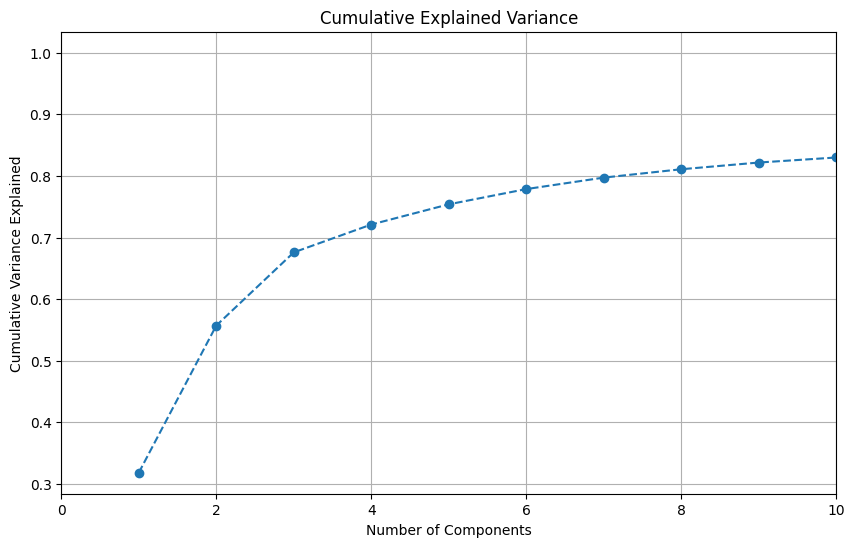

In [11]:
# Extract country names
countries = education_df['Country Name']

# Drop non-numeric columns (like country names and codes)
data_numeric = education_df.drop(['Country Name', 'Country Code'], axis=1)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Perform PCA
pca = PCA()
pca.fit(data_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.xlim(0, 10)  # Limiting x-axis to values from 0 to 10
plt.grid(True)
plt.show()


# Perform PCA with 8 components
pca = PCA(n_components=8)
pca_data = pca.fit_transform(data_scaled)

# Create DataFrame for PCA results
pca_columns = [f"PC{i}" for i in range(1, 9)]  # PC1 to PC8 column names
pca_df = pd.DataFrame(pca_data, columns=pca_columns)

# Add 'Country Name' to the PCA DataFrame
pca_df['Country Name'] = countries.reset_index(drop=True)  # Resetting index to ensure alignment

# Make the Country Name column the first column
pca_df = pca_df[['Country Name'] + pca_columns]

# Rename country name as pca_name
pca_df.rename(columns={'Country Name': 'pca_name'}, inplace=True)

# Pivoting the acled DataFrame
# acled_df = acled_df.pivot(index='Country', columns='Year', values='Events')

# only keep column from 2018 to 2023
# acled_df = acled_df.loc[:, 2018:2023]

In [12]:
country_mapping = {
    'Antigua and Barbuda': 'Antigua & Barbuda',
    'Bahamas, The': 'Bahamas',
    "Cote d'Ivoire": "Ivory Coast",
    'Czech Republic': 'Czechia',
    'Congo, Dem. Rep.': 'DR Congo (Zaire)',
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    'Iran, Islamic Rep.': 'Iran',
    'Micronesia, Fed. Sts.': 'Federated States of Micronesia',
    'Venezuela, RB': 'Venezuela',
    'Korea, Dem. People’s Rep.': 'North Korea',
    'Korea, Rep.': 'South Korea',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Yemen, Rep.': 'Yemen',
    'Macedonia, FYR': 'North Macedonia',
    'Timor-Leste': 'East Timor',
    'Russian Federation': 'Russia (Soviet Union)',
    'United States': 'United States of America',
    'Eswatini': 'Kingdom of eSwatini (Swaziland)',
    'Madagascar': 'Madagascar (Malagasy)',
    'Myanmar': 'Myanmar (Burma)',
    'Bolivia': 'Bolivia',
    'Bosnia and Herzegovina': 'Bosnia-Herzegovina',
    'Comoros': 'Comoros',
    'Congo, Rep.': 'Congo',
    'Germany': 'Germany',
    'Serbia': 'Serbia (Yugoslavia)',
    'Samoa': 'Samoa/Western Samoa',
    'Saint Kitts and Nevis': 'Saint Kitts and Nevis',
    'Saint Lucia': 'Saint Lucia',
    'Saint Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Sao Tome and Principe': 'Sao Tome and Principe',
    'Syria': 'Syrian Arab Republic',
    'North Korea': "Korea, Democratic People's Republic of",
    'South Korea': 'Korea, Republic of',
    'Turkey': 'Türkiye',
    'Vietnam': 'Vietnam (North Vietnam)',
    'Laos': 'Lao PDR',
    'Kosovo': 'Kosovo',
    'American Samoa': 'American Samoa',
    'Aruba': 'Aruba',
    'Bermuda': 'Bermuda',
    'British Virgin Islands': 'British Virgin Islands',
    'Cambodia': 'Cambodia (Kampuchea)',
    'Cayman Islands': 'Cayman Islands',
    'Channel Islands': 'Channel Islands',
    'Curacao': 'Curacao',
    'Czechia': 'Czech Republic',
    'Faroe Islands': 'Faroe Islands',
    'French Polynesia': 'French Polynesia',
    'Gibraltar': 'Gibraltar',
    'Greenland': 'Greenland',
    'Guam': 'Guam',
    'Hong Kong SAR, China': 'Hong Kong SAR, China',
    'Isle of Man': 'Isle of Man',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macao SAR, China',
    'New Caledonia': 'New Caledonia',
    'Northern Mariana Islands': 'Northern Mariana Islands',
    'Puerto Rico': 'Puerto Rico',
    'Sint Maarten (Dutch part)': 'Sint Maarten (Dutch part)',
    'Slovak Republic': 'Slovakia',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'St. Lucia': 'Saint Lucia',
    'St. Martin (French part)': 'St. Martin (French part)',
    'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Swaziland': 'Kingdom of eSwatini (Swaziland)',
    'Syrian Arab Republic': 'Syria',
    'Turks and Caicos Islands': 'Turks and Caicos Islands',
    'Türkiye': 'Turkey',
    'Virgin Islands (U.S.)': 'Virgin Islands (U.S.)',
    'West Bank and Gaza': 'West Bank and Gaza',
}

additional_country_mapping = {
    'Korea, Republic of': 'South Korea',
    'Korea, Democratic People\'s Republic of': 'North Korea',
    'Yemen': 'Yemen (North Yemen)',
    'Zimbabwe': 'Zimbabwe (Rhodesia)'
}
# Update the remaining mappings
remaining_country_mapping = {
    'Czechia': 'Czech Republic',
    'Hong Kong SAR, China': 'Hong Kong SAR, China',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macao SAR, China',
    'Syrian Arab Republic': 'Syria',
    'Türkiye': 'Turkey',
    'West Bank and Gaza': 'West Bank and Gaza'
}

# Update with additional mappings
country_mapping.update(additional_country_mapping)

# Remove duplicates from remaining_country_mapping
remaining_country_mapping = {v: v for v in remaining_country_mapping.values()}

# Merge all mappings into one dictionary
country_mapping.update(remaining_country_mapping)

# Apply the updated mapping to pca_df
pca_df['pca_name'] = pca_df['pca_name'].map(lambda x: country_mapping.get(x, x))

# Check for remaining non-matches
remaining_non_matches = set(pca_df['pca_name'].unique()) - set(main_df['country_cy'].unique())
print("Remaining Non-Matches:")
print(sorted(remaining_non_matches))



Remaining Non-Matches:
['American Samoa', 'Arab World', 'Aruba', 'Bermuda', 'British Virgin Islands', 'Cayman Islands', 'Channel Islands', 'Curacao', 'East Asia & Pacific', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (excluding high income)', 'European Union', 'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guam', 'Heavily indebted poor countries (HIPC)', 'High income', 'Hong Kong SAR, China', 'Isle of Man', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)', 'Least developed countries: UN classification', 'Low & middle income', 'Low income', 'Lower middle income', 'Macao SAR, China', 'Middle East & North Africa', 'Middle East & North Africa (excluding high income)', 'Middle income', 'New Caledonia', 'North America', 'Northern Mariana Islands', 'OECD members', 'Puerto Rico', 'Sint Maarten (Dutch part)', 'South Asia', 'St. Martin (French part)', 'Sub-Saharan Africa', 'Sub-Sahara

In [13]:
# Merge the dataframes
prepcluster_df = pd.merge(gdp_df, pca_df, left_on='gdp_name', right_on='pca_name')

# Drop the redundant 'pca_name' column
prepcluster_df.drop(columns=['pca_name'], inplace=True)

# Select the GDP columns and principal components
gdp_features = prepcluster_df.loc[:, '1989':'2022'].copy()
pc_features = prepcluster_df.loc[:, 'PC1':'PC8'].copy()  # Adjust if you have more PCs

# Apply log transformation to GDP columns
log_transformed_gdp = gdp_features.applymap(lambda x: np.log1p(x))

# Standardize the log-transformed GDP features
scaler = StandardScaler()
standardized_log_gdp = scaler.fit_transform(log_transformed_gdp)

# Standardize the principal components
standardized_pcs = scaler.fit_transform(pc_features)

# Combine the standardized log-transformed GDP and principal components
combined_features = np.hstack((standardized_log_gdp, standardized_pcs))

C:\Users\troen\AppData\Local\Temp\ipykernel_24080\3655312676.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_transformed_gdp = gdp_features.applymap(lambda x: np.log1p(x))


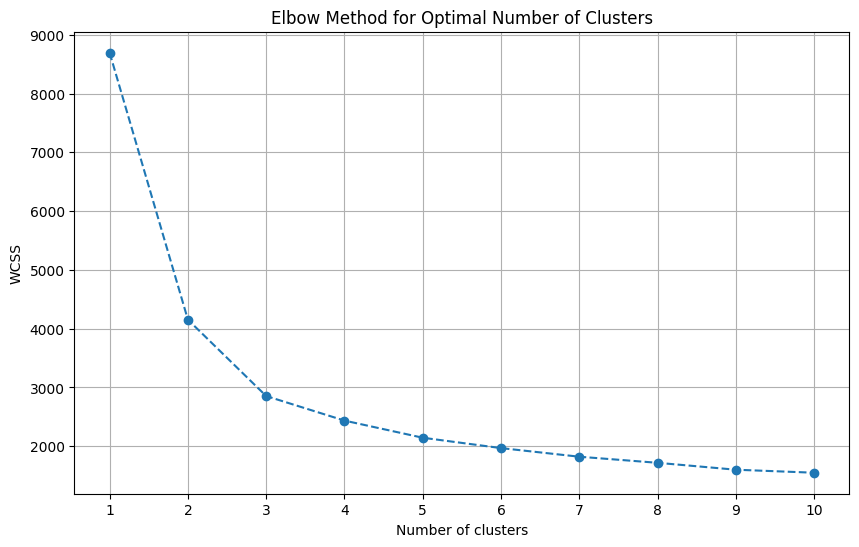

In [14]:
# Function to calculate WCSS for different number of clusters
def calculate_wcss(data):
    wcss = []
    for n in range(1, 11):  # You can adjust the range if needed
        kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Calculate WCSS
wcss = calculate_wcss(combined_features)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

optimal_clusters = 5  # Adjust based on elbow plot

# Run K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(combined_features)

# Add the cluster labels to your original DataFrame
prepcluster_df['Cluster'] = clusters

# Create a new DataFrame with 'gdp_name' and 'Cluster'
country_clusters_df = prepcluster_df[['gdp_name', 'Cluster']]


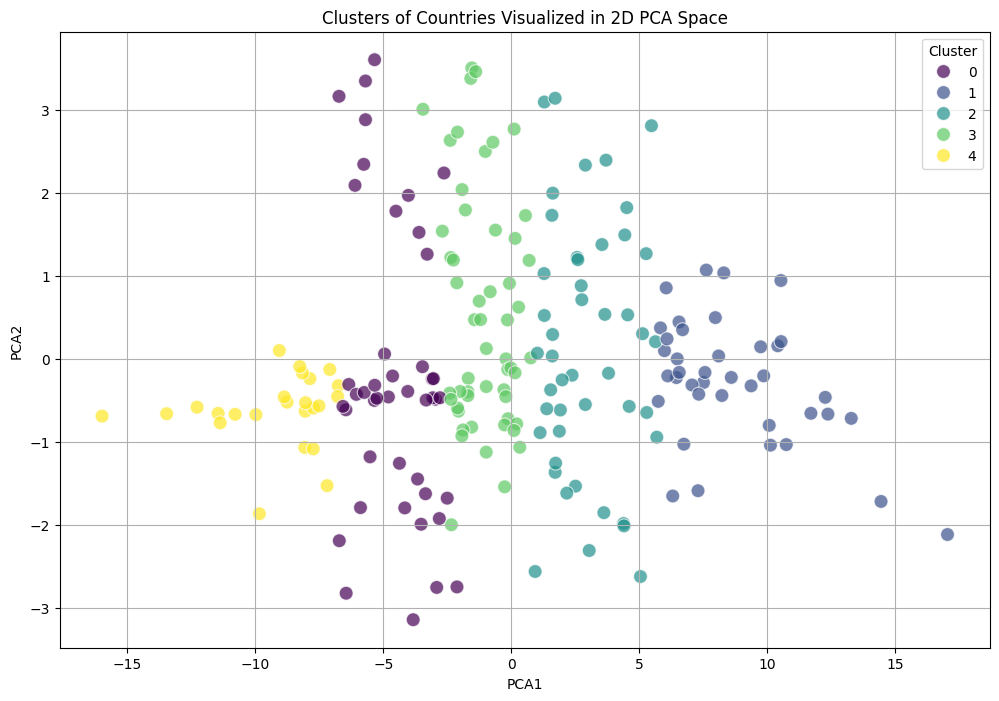

Cluster 0:
['Niger' 'French Polynesia' 'Sierra Leone' 'San Marino' 'Suriname'
 'Kingdom of eSwatini (Swaziland)' 'Sint Maarten (Dutch part)' 'Chad'
 'Togo' 'Tajikistan']

Cluster 1:
['Portugal' 'Russia (Soviet Union)' 'Saudi Arabia' 'Singapore' 'Sweden'
 'Thailand' 'Turkey' 'United States of America' 'Venezuela' 'South Africa']

Cluster 2:
['Sudan' 'Serbia (Yugoslavia)' 'Slovakia' 'Slovenia' 'Syria' 'Tunisia'
 'Ukraine' 'Uruguay' 'Uzbekistan' 'Vietnam (North Vietnam)']

Cluster 3:
['Senegal' 'El Salvador' 'Somalia' 'South Sudan' 'Turkmenistan'
 'Trinidad and Tobago' 'Tanzania' 'Uganda' 'Zambia' 'Zimbabwe (Rhodesia)']

Cluster 4:
['Solomon Islands' 'Sao Tome and Principe' 'Seychelles'
 'Turks and Caicos Islands' 'East Timor' 'Tonga' 'Tuvalu'
 'Saint Vincent and the Grenadines' 'Vanuatu' 'Samoa/Western Samoa']



In [15]:
# Reduce the combined features to 2 dimensions using PCA for visualization
pca_visual = PCA(n_components=2)
pca_2d = pca_visual.fit_transform(combined_features)

# Create a DataFrame with the 2D PCA results
pca_df = pd.DataFrame(data=pca_2d, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters
pca_df['gdp_name'] = prepcluster_df['gdp_name']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters of Countries Visualized in 2D PCA Space')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

for cluster in range(optimal_clusters):
    print(f"Cluster {cluster}:")
    cluster_df = prepcluster_df.loc[prepcluster_df['Cluster'] == cluster, 'gdp_name']
    if len(cluster_df) > 5:
        print(cluster_df.tail(10).values)
    else:
        print(cluster_df.values)
    print()

In [16]:

# Step 1: Ensure there are no conflicts by renaming columns if necessary
country_clusters_df = country_clusters_df.rename(columns={'gdp_name': 'country_cy', 'Cluster': 'Cluster_cluster'})

# Step 2: Perform the merge with custom suffixes to avoid conflicts
main_df = pd.merge(main_df, country_clusters_df, on='country_cy', how='left', suffixes=('', '_cluster'))

# Step 3: Remove rows where 'Cluster_cluster' is NaN
main_df = main_df[main_df['Cluster_cluster'].notna()]

# Step 4: Remove the unnecessary columns
columns_to_drop = ['country_id_cy', 'sb_dyad_ids_cy', 'ns_dyad_ids_cy', 'os_dyad_ids_cy','cumulative_total_deaths_unknown_in_orgvio_cy']
main_df = main_df.drop(columns=columns_to_drop)

main_df = main_df.rename(columns={'Cluster_cluster': 'gdp_education'})




In [17]:
# Ensure the data is sorted by country and year
main_df = main_df.sort_values(by=['country_cy', 'year_cy'])

# Initialize a new column for the years since last civilian death
main_df['years_since_last_civilian_death'] = None

# Dictionary to keep track of the last year a civilian death occurred for each country
last_death_year_civilian = {}
# Dictionary to keep track of whether deaths were recorded in the current year
current_year_deaths_civilian = {}

# Iterate through the DataFrame
for index, row in main_df.iterrows():
    country = row['country_cy']
    year = row['year_cy']
    deaths_civilian = row['cumulative_total_deaths_civilians_in_orgvio_cy']
    
    # Check if the country has been encountered before
    if country in last_death_year_civilian:
        if deaths_civilian > 0:
            # Set the years since last civilian death to the same as last year as we don't know this year's deaths yet
            main_df.at[index, 'years_since_last_civilian_death'] = year - last_death_year_civilian[country]
            # Update the last death year to the current year
            last_death_year_civilian[country] = year
            # Set flag for current year deaths
            current_year_deaths_civilian[country] = True
        else:
            if country in current_year_deaths_civilian and current_year_deaths_civilian[country]:
                # This is the year after deaths occurred, so reset the counter
                main_df.at[index, 'years_since_last_civilian_death'] = 0
                last_death_year_civilian[country] = year
                current_year_deaths_civilian[country] = False
            else:
                # Calculate the difference between the current year and the last recorded year of death
                main_df.at[index, 'years_since_last_civilian_death'] = year - last_death_year_civilian[country]
    else:
        if deaths_civilian == 0:
            # Initialize with the difference from 1989 as there is no prior year of death
            main_df.at[index, 'years_since_last_civilian_death'] = year - 1989
        else:
            # Initialize with the difference from 1989 and set the flag for current year deaths
            main_df.at[index, 'years_since_last_civilian_death'] = year - 1989
            last_death_year_civilian[country] = year
            current_year_deaths_civilian[country] = True

# Fill the missing values with 0 (this might not be necessary if logic is correct)
main_df['years_since_last_civilian_death'] = main_df['years_since_last_civilian_death'].fillna(0)

# Convert 'years_since_last_civilian_death' to integer type for better handling
main_df['years_since_last_civilian_death'] = main_df['years_since_last_civilian_death'].astype(int)

### Also do that for cumulative_best

# Dictionary to keep track of the last year a death occurred for each country
last_death_year_best = {}
# Dictionary to keep track of whether deaths were recorded in the current year
current_year_deaths = {}

# Iterate through the DataFrame
for index, row in main_df.iterrows():
    country = row['country_cy']
    year = row['year_cy']
    deaths_best = row['cumulative_total_deaths_in_orgvio_best_cy']
    
    # Check if the country has been encountered before
    if country in last_death_year_best:
        if deaths_best > 0:
            # Set the years since last death to the same as last year as we don't know this year's deaths yet
            main_df.at[index, 'years_since_last_death'] = year - last_death_year_best[country]
            # Update the last death year to the current year
            last_death_year_best[country] = year
            # Set flag for current year deaths
            current_year_deaths[country] = True
        else:
            if country in current_year_deaths and current_year_deaths[country]:
                # This is the year after deaths occurred, so reset the counter
                main_df.at[index, 'years_since_last_death'] = 0
                last_death_year_best[country] = year
                current_year_deaths[country] = False
            else:
                # Calculate the difference between the current year and the last recorded year of death
                main_df.at[index, 'years_since_last_death'] = year - last_death_year_best[country]
    else:
        if deaths_best == 0:
            # Initialize with the difference from 1989 as there is no prior year of death
            main_df.at[index, 'years_since_last_death'] = year - 1989
        else:
            # Initialize with the difference from 1989 and set the flag for current year deaths
            main_df.at[index, 'years_since_last_death'] = year - 1989
            last_death_year_best[country] = year
            current_year_deaths[country] = True

# Fill the missing values with 0 (this might not be necessary if logic is correct)
main_df['years_since_last_death'] = main_df['years_since_last_death'].fillna(0)

# Convert 'years_since_last_death' to integer type for better handling
main_df['years_since_last_death'] = main_df['years_since_last_death'].astype(int)

C:\Users\troen\AppData\Local\Temp\ipykernel_24080\1843409872.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_df['years_since_last_civilian_death'] = main_df['years_since_last_civilian_death'].fillna(0)


In [18]:
# Define the new column order
new_column_order = [
    'country_cy', 'gdp_education', 'year_cy', 'region_cy', 'sb_dyad_count_cy',
    'incompatibility', 'sb_intrastate_main_govt_inv_incomp_cy',
    'sb_interstate_main_govt_inv_incomp_cy', 'ns_dyad_count_cy', 'org',
    'os_dyad_count_cy', 'os_main_govt_inv_cy', 'os_any_govt_inv_cy',
    'os_nsgroup_inv_cy', 'years_since_last_civilian_death', 'years_since_last_death',
    'cumulative_total_deaths_parties_in_orgvio_cy', 'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]

# Reorder the DataFrame columns
main_df = main_df[new_column_order]

In [26]:
# Subset main_df for only year 2015 to 2022
# Filter rows based on condition
naive_df = main_df[(main_df['year_cy'] >= 2015) & (main_df['year_cy'] <= 2022)]

# Keep only specified columns
naive_df = naive_df[['country_cy', 'year_cy', 'cumulative_total_deaths_in_orgvio_best_cy']]


# Sort the dataframe by country and year
naive_df = naive_df.sort_values(by=['country_cy', 'year_cy'])

# Shift the 'cumulative_total_deaths_in_orgvio_best_cy' column by one year for each country
naive_df['previous_year_deaths'] = naive_df.groupby('country_cy')['cumulative_total_deaths_in_orgvio_best_cy'].shift(1)

# Drop rows with NaN values (for the first year of each country)
naive_df.dropna(inplace=True)

# Calculate the absolute errors
naive_df_sorted['absolute_error'] = abs(naive_df_sorted['cumulative_total_deaths_in_orgvio_best_cy'] - naive_df_sorted['previous_year_deaths'])

# Calculate the Mean Absolute Error (MAE)
total_mae = naive_df_sorted['absolute_error'].mean()

print("Total MAE Main_df:", total_mae)

Total MAE Main_df: 336.02081784386615


In [155]:
# Deleting all variables except main_df
all_vars = list(globals().keys())

# Loop through all variables and delete all except 'df_keep'
for var in all_vars:
    if var != 'main_df' and var[0] != "_":
        del globals()[var]

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam, SGD
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator

In [157]:
named_df = main_df.copy()
# Convert the 'country_cy' column to categorical and get the codes
country_cats = main_df['country_cy'].astype('category')
main_df['country_cy'] = country_cats.cat.codes

# Create a dictionary mapping for 'country_cy'
country_dict = dict(enumerate(country_cats.cat.categories))

# Convert the 'region_cy' column to categorical and get the codes
region_cats = main_df['region_cy'].astype('category')
main_df['region_cy'] = region_cats.cat.codes

# Create a dictionary mapping for 'region_cy'
region_dict = dict(enumerate(region_cats.cat.categories))

In [27]:

columns_to_check = ['sb_dyad_count_cy', 'incompatibility', 'sb_intrastate_main_govt_inv_incomp_cy',
                    'sb_interstate_main_govt_inv_incomp_cy', 'ns_dyad_count_cy', 'os_dyad_count_cy',
                    'os_main_govt_inv_cy', 'os_any_govt_inv_cy', 'os_nsgroup_inv_cy',
                    'cumulative_total_deaths_parties_in_orgvio_cy', 'cumulative_total_deaths_civilians_in_orgvio_cy',
                    'cumulative_total_deaths_in_orgvio_best_cy']

# Check if all specified columns are equal to 0 and create a boolean mask
mask = (main_df[columns_to_check] == 0).all(axis=1)

# Filter the DataFrame to keep rows where the mask is False (i.e., not all specified columns are equal to 0)
subset_df = main_df[~mask]

target_columns = ['cumulative_total_deaths_parties_in_orgvio_cy', 
                  'cumulative_total_deaths_civilians_in_orgvio_cy',
                  'cumulative_total_deaths_in_orgvio_best_cy']



In [28]:
# Filter rows based on condition
naive_sub_df = subset_df[(subset_df['year_cy'] >= 2015) & (subset_df['year_cy'] <= 2022)]

# Keep only specified columns
naive_sub_df = naive_sub_df[['country_cy', 'year_cy', 'cumulative_total_deaths_in_orgvio_best_cy']]


# Sort the dataframe by country and year
naive_sub_df = naive_sub_df.sort_values(by=['country_cy', 'year_cy'])

# Shift the 'cumulative_total_deaths_in_orgvio_best_cy' column by one year for each country
naive_sub_df['previous_year_deaths'] = naive_sub_df.groupby('country_cy')['cumulative_total_deaths_in_orgvio_best_cy'].shift(1)

# Drop rows with NaN values (for the first year of each country)
naive_sub_df.dropna(inplace=True)

# Calculate the absolute errors
naive_sub_df['absolute_error'] = abs(naive_sub_df['cumulative_total_deaths_in_orgvio_best_cy'] - naive_sub_df['previous_year_deaths'])

# Calculate the Mean Absolute Error (MAE)
total_mae_sub = naive_sub_df['absolute_error'].mean()

print("Total MAE:", total_mae_sub)

Total MAE: 1177.3054830287206


In [ ]:

################################################
# START OF SUPERVISED LEARNING
################################################

# Define the cutoff year for training and validation
cutoff_year = 2015 # A cutoff in 2017 means 85% of the data will be used for training

# Split the data into training and initial validation
train_df = subset_df[subset_df['year_cy'] < cutoff_year]
validation_df = subset_df[subset_df['year_cy'] >= cutoff_year]

# Shuffle the train and validation dataframes
train_df = shuffle(train_df, random_state=42)
validation_df = shuffle(validation_df, random_state=42)

# Further split the validation_df into validation and test sets (50-50 split)
validation_df, test_df = train_test_split(validation_df, test_size=0.5, random_state=42)

# Define features (X) and targets (y) for training
x_train = train_df.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])

y_train = train_df[[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

# Define features (X) and targets (y) for validation
x_validation = validation_df.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])

y_validation = validation_df[[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

# Define features (X) and targets (y) for test
x_test = test_df.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])

y_test = test_df[[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]


scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_validation = scaler.transform(y_validation)
y_test = scaler.transform(y_test)

In [ ]:
input_dim = x_train.shape[1]

### Model with all the features

# Define your model
model_1 = Sequential()

# Add layers to the model
model_1.add(Dense(64, activation='relu', input_shape=(input_dim,)))
model_1.add(Dense(3, activation= "linear"))

# Set a reduced initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)


# Compile the model
model_1.compile(optimizer=optimizer, loss='mse', metrics=['mean_absolute_error'])

# Print the model summary
model_1.summary()

# Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor=0.1, patience=5, min_lr=1e-6)

# Training the model
history = model_1.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_validation, y_validation),
    callbacks= reduce_lr
)

# Evaluate the model
loss, mae = model_1.evaluate(x_validation, y_validation)
print(f"Mean Absolute Error on test data: {mae}")

# Make predictions
y_pred = model_1.predict(x_validation)

# Calculate additional performance metrics
mse = mean_squared_error(y_validation, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_validation, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

# Scatter plots: Actual vs Predicted values for each target variable
targets = ['Parties in Orgvio', 'Civilians in Orgvio', 'Best Estimate']
for i, target in enumerate(targets):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_validation[:, i], y_pred[:, i], alpha=0.3)
    plt.plot([min(y_validation[:, i]), max(y_validation[:, i])], [min(y_validation[:, i]), max(y_validation[:, i])], color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Scatter plot for {target}')
    plt.show()

# Residual plots for each target variable
residuals = y_validation - y_pred

targets = ['Parties in Orgvio', 'Civilians in Orgvio', 'Best Estimate']
for i, target in enumerate(targets):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_validation[:, i], y_pred[:, i], alpha=0.3)
    plt.plot([min(y_validation[:, i]), max(y_validation[:, i])], [min(y_validation[:, i]), max(y_validation[:, i])], color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Scatter plot for {target}')
    plt.show()

# Learning curves: Training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Flatten
y_pred_flat = y_pred.flatten()

# Comparison table of actual vs predicted values including index
comparison_df = pd.DataFrame({
    'Index': validation_df.index,  # Assuming you have a unique index for each observation
    'Actual_Parties_in_Orgvio': y_validation[:, 0],
    'Predicted_Parties_in_Orgvio': y_pred_flat[:len(y_validation)],
    'Actual_Civilians_in_Orgvio': y_validation[:, 1],
    'Predicted_Civilians_in_Orgvio': y_pred_flat[len(y_validation): 2*len(y_validation)],
    'Actual_Best_Estimate': y_validation[:, 2],
    'Predicted_Best_Estimate': y_pred_flat[2*len(y_validation):]
})

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, model_1.predict(x_train)))
train_mae = mean_absolute_error(y_train, model_1.predict(x_train))
train_r2 = r2_score(y_train, model_1.predict(x_train))

# Calculate metrics for Validation set
test_rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
test_mae = mean_absolute_error(y_validation, y_pred)
test_r2 = r2_score(y_validation, y_pred)

# Create DataFrame for comparison
comparison_metrics_df = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse, train_mae, train_r2],
    'Test': [test_rmse, test_mae, test_r2]
})

print(comparison_metrics_df)

In [159]:
################################################
# Predict 1 variable
################################################
# Define the cutoff year for training and validation
cutoff_year_2 = 2015

# Split the data into training and initial validation
train_df_2 = subset_df[subset_df['year_cy'] < cutoff_year_2]
validation_df_2 = subset_df[subset_df['year_cy'] >= cutoff_year_2]

# Shuffle the train and validation dataframes
#train_df_2 = shuffle(train_df_2, random_state=42)
#validation_df_2 = shuffle(validation_df_2, random_state=42)

# Further split the validation_df into validation and test sets (50-50 split)
validation_df_2, test_df_2 = train_test_split(validation_df_2, test_size=0.5, random_state=42)

# Define features (X) and targets (y) for training
x_train_2 = train_df_2.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])

y_train_2 = train_df_2[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for validation
x_validation_2 = validation_df_2.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_validation_2 = validation_df_2[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for test
x_test_2 = test_df_2.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test_2 = test_df_2[['cumulative_total_deaths_in_orgvio_best_cy']]


#scaler = QuantileTransformer()
#y_train_2 = scaler.fit_transform(y_train_2)
#y_validation_2 = scaler.transform(y_validation_2)
#y_test_2 = scaler.transform(y_test_2)

C:\Users\troen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,473 (37.00 KB)

 Trainable params: 9,473 (37.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2009.7037 - mean_absolute_error: 2009.7037 - val_loss: 1881.6606 - val_mean_absolute_error: 1881.6606 - learning_rate: 0.0100
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1740.8016 - mean_absolute_error: 1740.8016 - val_loss: 1863.4155 - val_mean_absolute_error: 1863.4155 - learning_rate: 0.0100
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1224.9072 - mean_absolute_error: 1224.9072 - val_loss: 1844.6157 - val_mean_absolute_error: 1844.6157 - learning_rate: 0.0100
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1168.0778 - mean_absolute_error: 1168.0778 - val_loss: 1808.8948 - val_mean_absolute_error: 1808.8948 - learning_rate: 0.0100
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1940.8510 - mean_absolute_error: 1940.8510 - val_loss: 1760.8300 - val_mean_absolute_error: 1760.8300 - learning_rate: 0.0100
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1950.0398 - mean

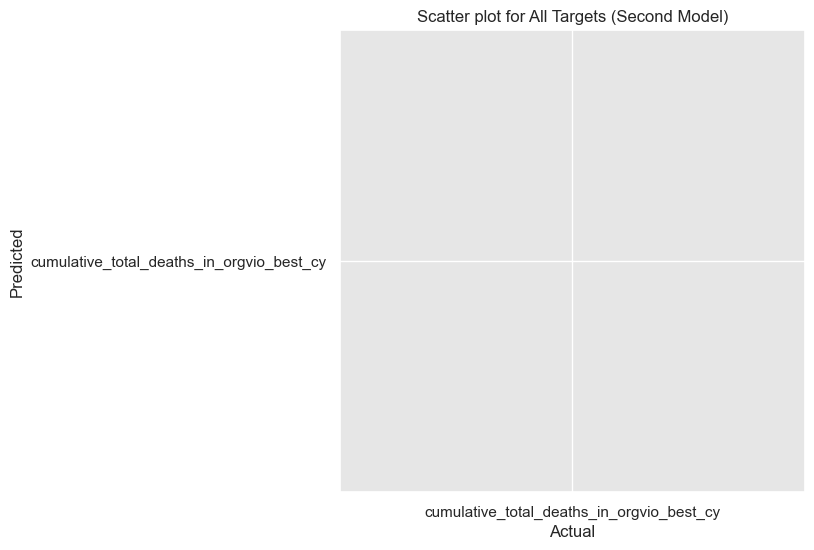

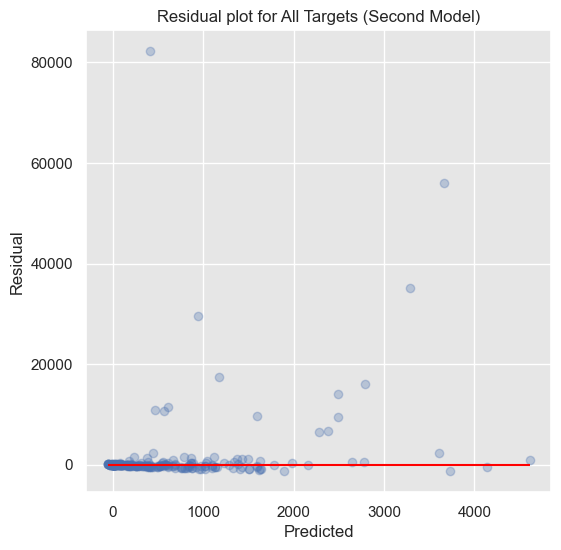

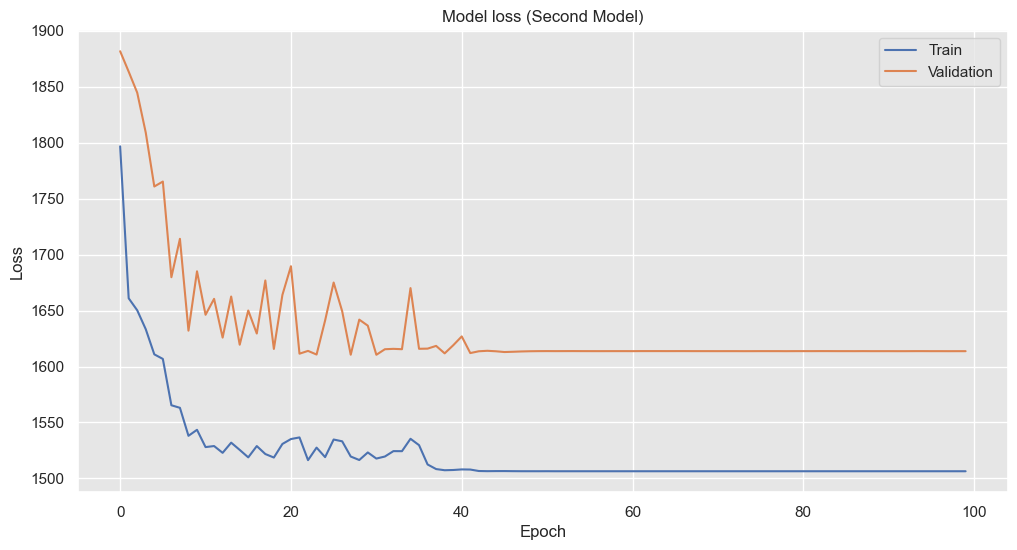

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
     Metrics      Training         Test
0       RMSE  20928.275101  7532.125232
1        MAE   1506.425126  1613.709418
2  R-Squared     -0.000475     0.037381


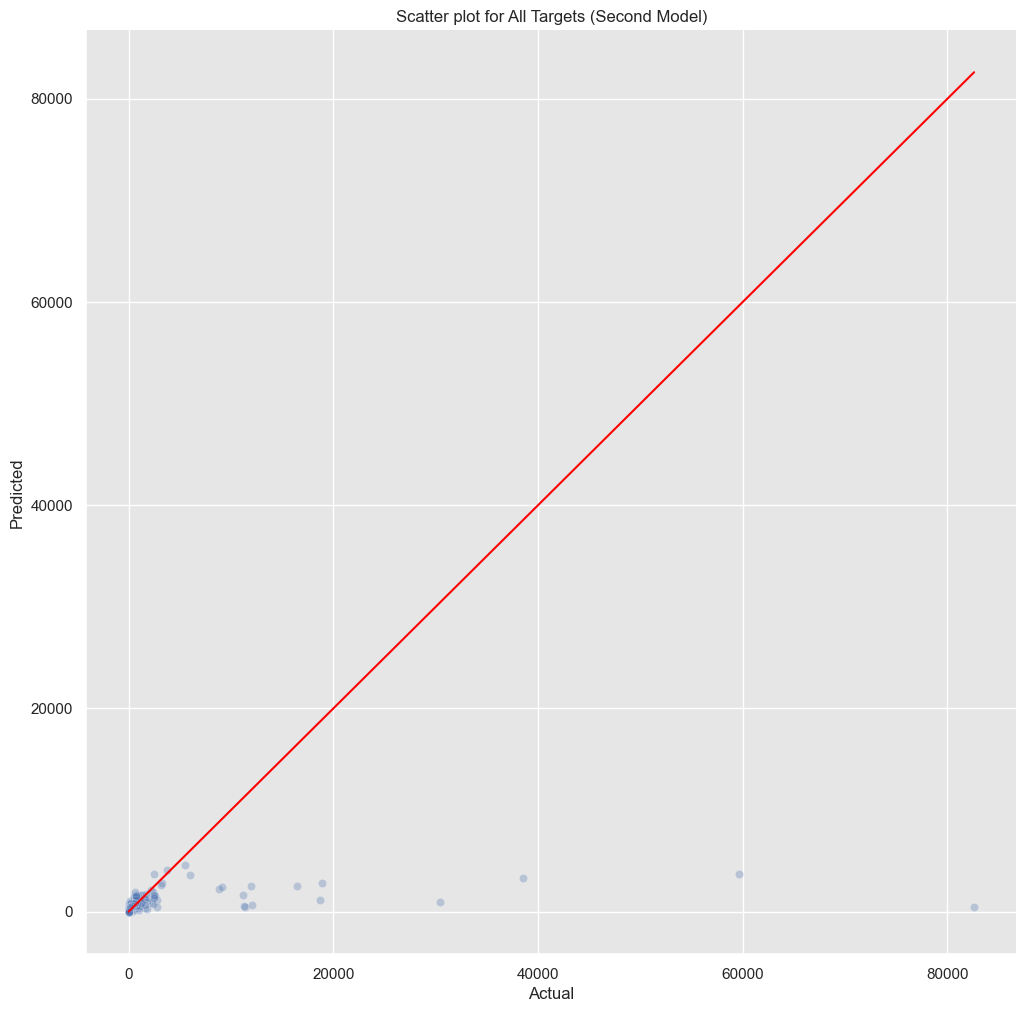

In [160]:
# Define the input dimension for the second model
input_dim_2 = x_train_2.shape[1]

# Define your second model
model_2 = Sequential()

# Add layers to the second model
model_2.add(Dense(64, activation='linear', input_shape=(input_dim_2,)))
model_2.add(Dense(64, activation='linear'))
model_2.add(Dense(64, activation='linear'))
model_2.add(Dense(1, activation="linear"))


initial_learning_rate_2 = 0.01
optimizer_2 = Adam(learning_rate=initial_learning_rate_2)

# Compile the second model
model_2.compile(optimizer=optimizer_2, loss= "mean_absolute_error", metrics=['mean_absolute_error'])

# Print the second model summary
model_2.summary()

# Define callbacks for the second model
# early_stopping_2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_2 =  ReduceLROnPlateau(monitor = "val_loss", factor=0.1, patience=5, min_lr=1e-6)

# Training the second model
history_2 = model_2.fit(
    x_train_2, y_train_2,
    epochs=100,
    batch_size=32,
    validation_data=(x_validation_2, y_validation_2),
    callbacks= reduce_lr_2
)

# Evaluate the second model
loss_2, mae_2 = model_2.evaluate(x_validation_2, y_validation_2)
print(f"Mean Absolute Error on Validation data (Second Model): {mae_2}")

# Make predictions with the second model
y_pred_2 = model_2.predict(x_validation_2)


# Calculate additional performance metrics for the second model
mse_2 = mean_squared_error(y_validation_2, y_pred_2)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_validation_2, y_pred_2)

print(f"Mean Squared Error (Second Model): {mse_2}")
print(f"Root Mean Squared Error (Second Model): {rmse_2}")
print(f"R-squared (Second Model): {r2_2}")

# Scatter plots: Actual vs Predicted values for each target variable for the second model
plt.figure(figsize=(6, 6))
plt.scatter(y_validation_2, y_pred_2, alpha=0.3)
plt.plot([min(y_validation_2), max(y_validation_2)], [min(y_validation_2), max(y_validation_2)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter plot for All Targets (Second Model)')
plt.show()

# Calculate residuals
residuals_2 = y_validation_2 - y_pred_2

# Residual plots for each target variable for the second model
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_2, residuals_2, alpha=0.3)
plt.hlines(0, min(y_pred_2), max(y_pred_2), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for All Targets (Second Model)')
plt.show()

# Learning curves: Training and validation loss over epochs for the second model
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss (Second Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Flatten the ndarray
y_pred_2_flat = y_pred_2.flatten()

# Construct the DataFrame
comparison_df_2 = pd.DataFrame({
    'Actual_Best_Estimate': y_validation_2.iloc[:, 0],
    'Predicted_Best_Estimate': y_pred_2_flat
})


# Unscale
# y_validation_unscale_2 = scaler.inverse_transform(y_validation_2)
# y_pred_unscale_2 = scaler.inverse_transform(y_pred_2)

# Calculate metrics for training set for the second model
train_rmse_2 = np.sqrt(mean_squared_error(y_train_2, model_2.predict(x_train_2)))
train_mae_2 = mean_absolute_error(y_train_2, model_2.predict(x_train_2))
train_r2_2 = r2_score(y_train_2, model_2.predict(x_train_2))

# Calculate metrics for test set for the second model
test_rmse_2 = np.sqrt(mean_squared_error(y_validation_2, y_pred_2))
test_mae_2 = mean_absolute_error(y_validation_2, y_pred_2)
test_r2_2 = r2_score(y_validation_2, y_pred_2)

# Create DataFrame for comparison for the second model
comparison_metrics_df_2 = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_2, train_mae_2, train_r2_2],
    'Test': [test_rmse_2, test_mae_2, test_r2_2]
})

print(comparison_metrics_df_2)

# Ensure the inputs are 1-dimensional arrays or Series
if isinstance(y_validation_2, pd.DataFrame):
    y_validation_2_sns = y_validation_2.values.flatten()
else:
    y_validation_2_sns = y_validation_2.flatten() if len(y_validation_2.shape) > 1 else y_validation_2

if isinstance(y_pred_2, pd.DataFrame):
    y_pred_2_sns = y_pred_2.values.flatten()
else:
    y_pred_2_sns = y_pred_2.flatten() if len(y_pred_2.shape) > 1 else y_pred_2

# Scatter plot: Actual vs Predicted values for the second model
plt.figure(figsize=(12, 12))
sns.scatterplot(x=y_validation_2_sns, y=y_pred_2_sns, alpha=0.3)
plt.plot([min(y_validation_2_sns), max(y_validation_2_sns)], [min(y_validation_2_sns), max(y_validation_2_sns)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter plot for All Targets (Second Model)')
sns.despine()
plt.show()

In [ ]:
#####################################
# Hyper parameter tuning
#####################################
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
warnings.filterwarnings('ignore', category=FutureWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging (1: INFO, 2: WARNING, 3: ERROR)

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import numpy as np

class KerasRegressorWrapper(BaseEstimator):
    def __init__(self, learning_rate=0.01, neurons=64, activation='linear', optimizer='Adam', dropout_rate=0.0, num_layers=3, batch_size=32, epochs=100):
        self.learning_rate = learning_rate
        self.neurons = neurons
        self.activation = activation
        self.optimizer = optimizer
        self.dropout_rate = dropout_rate
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.epochs = epochs

    def create_model(self):
        model = Sequential()
        model.add(Input(shape=(input_dim_2,)))
        model.add(Dense(self.neurons, activation=self.activation))
        
        for _ in range(self.num_layers - 1):
            model.add(Dense(self.neurons, activation=self.activation))
            if self.dropout_rate > 0.0:
                model.add(Dropout(self.dropout_rate))
            model.add(BatchNormalization())
        
        model.add(Dense(1, activation="linear"))
        
        if self.optimizer == 'Adam':
            opt = Adam(learning_rate=self.learning_rate)
        elif self.optimizer == 'SGD':
            opt = SGD(learning_rate=self.learning_rate)
        elif self.optimizer == 'RMSprop':
            opt = RMSprop(learning_rate=self.learning_rate)
        
        model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])
        return model

    def fit(self, X, y):
        self.model = self.create_model()
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)


# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'neurons': [32, 64],
    'activation': ['relu', 'linear'],
    'optimizer': ['Adam'],
    'dropout_rate': [0.0, 0.1],
    'num_layers': [2, 3, 4],
    'batch_size': [32, 64],
    'epochs': [100]
}

# Custom GridSearchCV class to track progress
class ProgressGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=np.nan, return_train_score=False):
        super().__init__(estimator=estimator, param_grid=param_grid, scoring=scoring, n_jobs=n_jobs, refit=refit, cv=cv, verbose=verbose, pre_dispatch=pre_dispatch, error_score=error_score, return_train_score=return_train_score)
        self.n_iter_ = 0
        self.total_iter_ = np.prod([len(v) for v in param_grid.values()])
    
    def fit(self, X, y=None, **fit_params):
        for params in self.param_grid:
            self.n_iter_ += 1
            print(f"Experiment {self.n_iter_}/{self.total_iter_}")
        return super().fit(X, y, **fit_params)

# Setup ProgressGridSearchCV with your wrapped model
grid = ProgressGridSearchCV(estimator=KerasRegressorWrapper(), param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=2)

# Perform the grid search
grid_result = grid.fit(x_train_2, y_train_2)

# Print the best parameters and the best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Train the model with the best parameters
best_model = grid_result.best_estimator_.create_model()
best_model.fit(x_train_2, y_train_2, batch_size=grid_result.best_params_['batch_size'], epochs=grid_result.best_params_['epochs'])

# Evaluate the best model
loss_2, mae_2 = best_model.evaluate(x_validation_2, y_validation_2)
print(f"Mean Absolute Error on Validation data (Best Model): {mae_2}")

# Make predictions with the best model
# y_pred_2 = best_model.predict(x_validation_2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Squared Error (Second Model): 70518586.59164658
Root Mean Squared Error (Second Model): 8397.534554358594
R-squared (Second Model): 0.017001485129024996


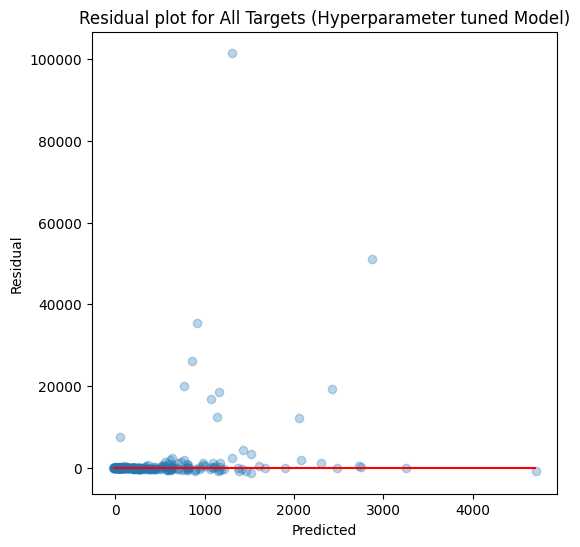

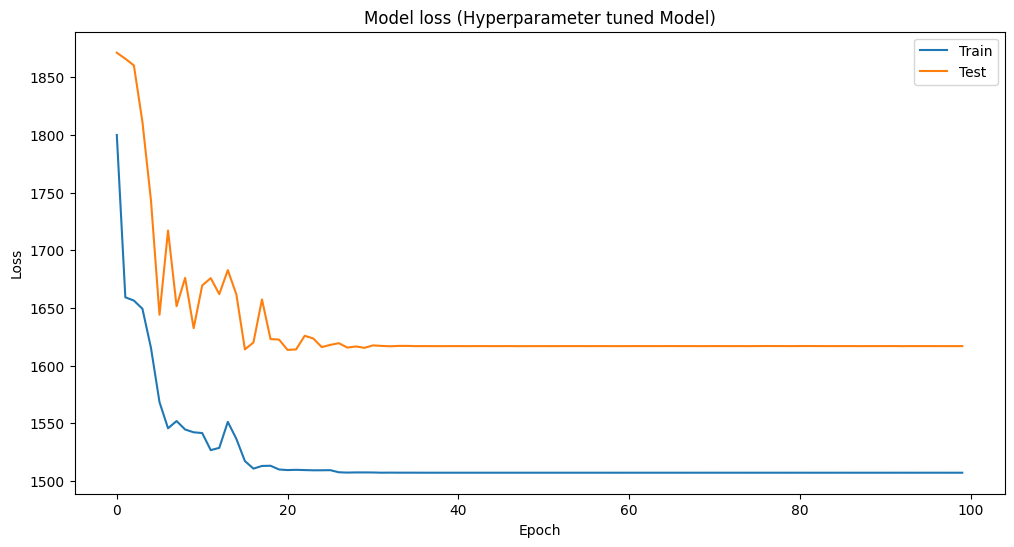

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


Model: "sequential_870"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3478 (Dense)              │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3479 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_868 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1732        │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3480 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_869 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1733        │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3481 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,581 (33.52 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 5,636 (22.02 KB)

None
     Metrics      Training         Test
0       RMSE  20929.041260  8397.534554
1        MAE   1507.062451  1652.760452
2  R-Squared     -0.000548     0.017001


In [71]:
# Make predictions with the best model
y_pred_2 = best_model.predict(x_test_2)

# Calculate additional performance metrics for the second model
mse_2 = mean_squared_error(y_test_2, y_pred_2)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_test_2, y_pred_2)

print(f"Mean Squared Error (Second Model): {mse_2}")
print(f"Root Mean Squared Error (Second Model): {rmse_2}")
print(f"R-squared (Second Model): {r2_2}")

# Scatter plots: Actual vs Predicted values for each target variable for the second model
#plt.figure(figsize=(12, 12))
#plt.scatter(y_test_2, y_pred_2, alpha=0.3)
#plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], color='red')
#plt.xlabel('Actual')
#plt.ylabel('Predicted')
#plt.title('Scatter plot for All Targets (Hyperparameter tuned Model)')
#plt.show()

# Calculate residuals
residuals_2 = y_test_2 - y_pred_2

# Residual plots for each target variable for the second model
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_2, residuals_2, alpha=0.3)
plt.hlines(0, min(y_pred_2), max(y_pred_2), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for All Targets (Hyperparameter tuned Model)')
plt.show()

# Learning curves: Training and validation loss over epochs for the second model
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss (Hyperparameter tuned Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Flatten the ndarray
y_pred_2_flat = y_pred_2.flatten()

# Construct the DataFrame
comparison_df_2 = pd.DataFrame({
    'Actual_Best_Estimate': y_test_2.iloc[:, 0],
    'Predicted_Best_Estimate': y_pred_2_flat
})


# Unscale
# y_validation_unscale_2 = scaler.inverse_transform(y_validation_2)
# y_pred_unscale_2 = scaler.inverse_transform(y_pred_2)
# Flatten the ndarray
y_pred_2_flat = y_pred_2.flatten()

# Construct the DataFrame
hypparam_comparison_df = pd.DataFrame({
    'Actual_Best_Estimate': y_test_2.iloc[:, 0],
    'Predicted_Best_Estimate': y_pred_2_flat
})
# Calculate metrics for training set for the second model
train_rmse_2 = np.sqrt(mean_squared_error(y_train_2, model_2.predict(x_train_2)))
train_mae_2 = mean_absolute_error(y_train_2, model_2.predict(x_train_2))
train_r2_2 = r2_score(y_train_2, model_2.predict(x_train_2))

# Calculate metrics for test set for the second model
test_rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_2))
test_mae_2 = mean_absolute_error(y_test_2, y_pred_2)
test_r2_2 = r2_score(y_test_2, y_pred_2)

# Create DataFrame for comparison for the second model
hyperparam_metrics_comparison_df = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_2, train_mae_2, train_r2_2],
    'Test': [test_rmse_2, test_mae_2, test_r2_2]
})

print(best_model.summary())
print(hyperparam_metrics_comparison_df)




In [25]:
model_2.save("best_model.h5")

In [25]:
model_2.evaluate(x_test_2, y_test_2)

# Create comparison DataFrame
comparison_df_2 = pd.DataFrame({
    'Actual_Best_Estimate': y_test_2.iloc[:, 0],
    'Predicted_Best_Estimate': y_pred_2_flat
})

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1314.5042 - mean_absolute_error: 1314.5042


In [60]:
#####################################
# Regression model
#####################################

# Preparation
subset_regr_df = subset_df.drop(columns=['cumulative_total_deaths_parties_in_orgvio_cy', 
                                'cumulative_total_deaths_civilians_in_orgvio_cy'])




Validation Mean Squared Error: 52188560.02165109
Validation Root Mean Squared Error: 7224.16500515119
Validation Mean Absolute Error: 3083.7170515236903
Validation R-squared: 0.11448780823577387


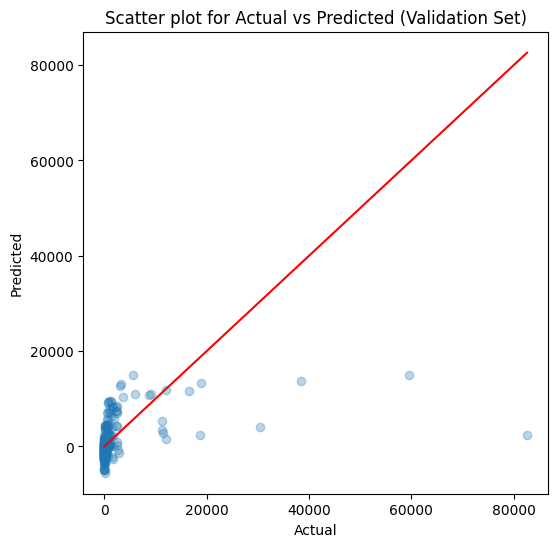

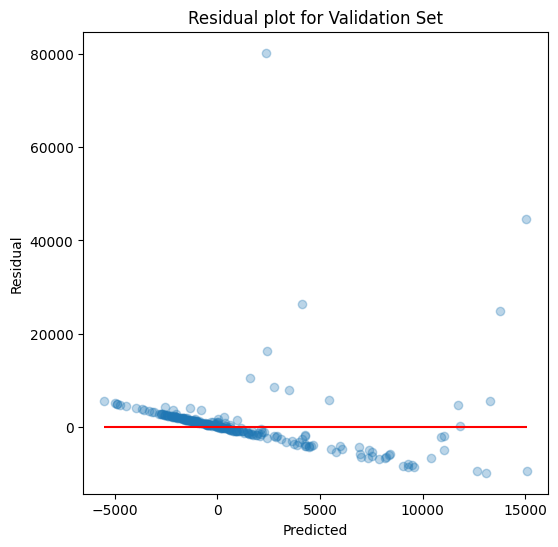

In [28]:
cutoff_year_regr = 2015

# Split the data into training and initial validation
train_df_regr = subset_regr_df[subset_regr_df['year_cy'] < cutoff_year_regr]
validation_df_regr = subset_regr_df[subset_regr_df['year_cy'] >= cutoff_year_regr]

# Further split the validation_df into validation and test sets (50-50 split)
validation_df_regr, test_df_regr = train_test_split(validation_df_regr, test_size=0.5, random_state=42)

# Define features (X) and targets (y) for training
x_train_regr = train_df_regr.drop(columns=[
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_train_regr = train_df_regr[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for validation
x_validation_regr = validation_df_regr.drop(columns=[
    'cumulative_total_deaths_in_orgvio_best_cy'
    ])
y_validation_regr = validation_df_regr[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for test
x_test_regr = test_df_regr.drop(columns=[
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test_regr = test_df_regr[['cumulative_total_deaths_in_orgvio_best_cy']]

# Create a linear regression model
linear_reg_model = LinearRegression()

# Fit the model to the training data
linear_reg_model.fit(x_train_regr, y_train_regr)

# Make predictions on the validation set
y_pred_validation_regr = linear_reg_model.predict(x_validation_regr)

# Evaluate the model on the validation set
mse_validation_regr = mean_squared_error(y_validation_regr, y_pred_validation_regr)
rmse_validation_regr = np.sqrt(mse_validation_regr)
mae_validation_regr = mean_absolute_error(y_validation_regr, y_pred_validation_regr)
r2_validation_regr = r2_score(y_validation_regr, y_pred_validation_regr)


print(f"Validation Mean Squared Error: {mse_validation_regr}")
print(f"Validation Root Mean Squared Error: {rmse_validation_regr}")
print(f"Validation Mean Absolute Error: {mae_validation_regr}")
print(f"Validation R-squared: {r2_validation_regr}")
# Make predictions on the test set
#y_pred_test_regr = linear_reg_model.predict(x_test_regr)

# Evaluate the model on the test set
#mse_test_regr = mean_squared_error(y_test_regr, y_pred_test_regr)
#rmse_test_regr = np.sqrt(mse_test_regr)
#mae_test_regr = mean_absolute_error(y_test_regr, y_pred_test_regr)
#r2_test_regr = r2_score(y_test_regr, y_pred_test_regr)

#print(f"Test Mean Squared Error: {mse_test_regr}")
#print(f"Test Root Mean Squared Error: {rmse_test_regr}")
#print(f"Test Mean Absolute Error: {mae_test_regr}")
#print(f"Test R-squared: {r2_test_regr}")

# Scatter plot: Actual vs Predicted values for the validation set
plt.figure(figsize=(6, 6))
plt.scatter(y_validation_regr, y_pred_validation_regr, alpha=0.3)
plt.plot([min(y_validation_regr.values), max(y_validation_regr.values)], [min(y_validation_regr.values), max(y_validation_regr.values)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter plot for Actual vs Predicted (Validation Set)')
plt.show()

# Scatter plot: Actual vs Predicted values for the test set
#plt.figure(figsize=(6, 6))
#plt.scatter(y_test_regr, y_pred_test_regr, alpha=0.3)
#plt.plot([min(y_test_regr.values), max(y_test_regr.values)], [min(y_test_regr.values), max(y_test_regr.values)], color='red')
#plt.xlabel('Actual')
#plt.ylabel('Predicted')
#plt.title('Scatter plot for Actual vs Predicted (Test Set)')
#plt.show()

# Residual plots for the validation set
residuals_validation_regr = y_validation_regr.values.flatten() - y_pred_validation_regr.flatten()
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_validation_regr, residuals_validation_regr, alpha=0.3)
plt.hlines(0, min(y_pred_validation_regr), max(y_pred_validation_regr), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for Validation Set')
plt.show()


comparison_df_validation = pd.DataFrame({
    'Actual': y_validation_regr.values.flatten(),
    'Predicted': y_pred_validation_regr.flatten()
})


# Residual plots for the test set
#residuals_test_regr = y_test_regr.values.flatten() - y_pred_test_regr.flatten()
#plt.figure(figsize=(6, 6))
#plt.scatter(y_pred_test_regr, residuals_test_regr, alpha=0.3)
#plt.hlines(0, min(y_pred_test_regr), max(y_pred_test_regr), colors='red')
#plt.xlabel('Predicted')
#plt.ylabel('Residual')
#plt.title('Residual plot for Test Set')
#plt.show()

Training Mean Squared Error (LASSO): 430318712.8367022
Training Root Mean Squared Error (LASSO): 20744.124778758494
Training Mean Absolute Error (LASSO): 2377.082830965396
Training R-squared (LASSO): 0.01705444620147134
Validation Mean Squared Error (LASSO): 52189591.280292146
Validation Root Mean Squared Error (LASSO): 7224.236380427495
Validation Mean Absolute Error (LASSO): 3083.5834660204173
Validation R-squared (LASSO): 0.11447031029946086


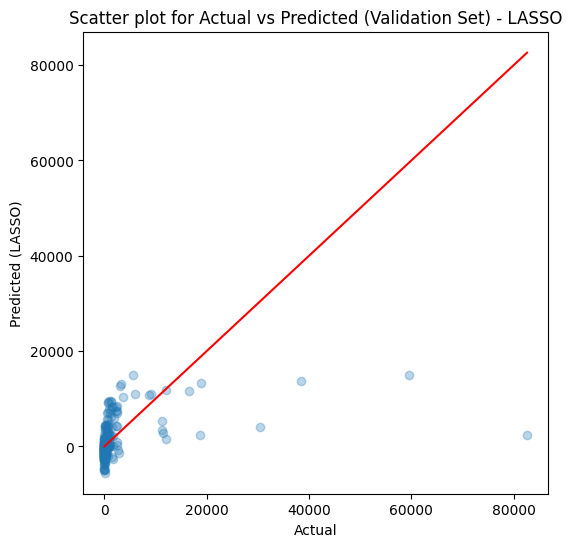

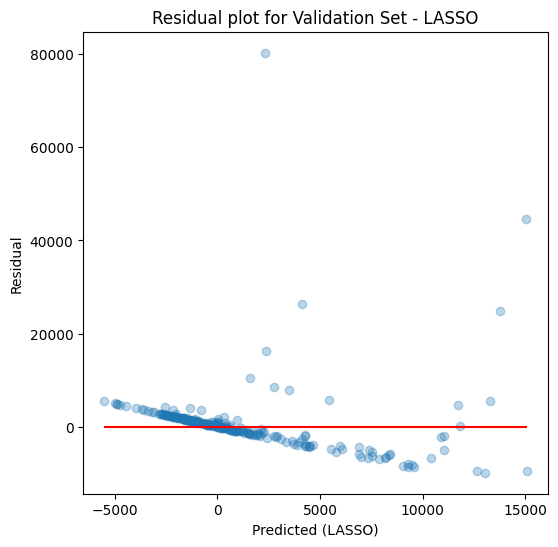

In [68]:
# Hyperparameter tuning for the linear regression model
from sklearn.linear_model import Lasso
# Define the parameter grid for hyperparameter tuning
cutoff_year_regr = 2015

# Split the data into training and initial validation
train_df_lasso = subset_regr_df[subset_regr_df['year_cy'] < cutoff_year_regr]
validation_df_lasso = subset_regr_df[subset_regr_df['year_cy'] >= cutoff_year_regr]

# Further split the validation_df into validation and test sets (50-50 split)
validation_df_lasso, test_df_lasso = train_test_split(validation_df_lasso, test_size=0.5, random_state=42)

# Define features (X) and targets (y) for training
x_train_lasso = train_df_lasso.drop(columns=[
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_train_lasso = train_df_lasso[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for validation
x_validation_lasso = validation_df_lasso.drop(columns=[
    'cumulative_total_deaths_in_orgvio_best_cy'
    ])
y_validation_lasso = validation_df_lasso[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for test
x_test_lasso = test_df_lasso.drop(columns=[
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test_lasso = test_df_lasso[['cumulative_total_deaths_in_orgvio_best_cy']]

# Create a Lasso regression model
lasso_model = Lasso(alpha=0.1) 

# Fit the model to the training data
lasso_model.fit(x_train_lasso, y_train_lasso)

y_pred_validation_lasso = lasso_model.predict(x_validation_lasso)

# Make predictions on the training set
y_pred_train_lasso = lasso_model.predict(x_train_lasso)

# Set negative predictions to 0
y_pred_train_lasso[y_pred_train_lasso < 0] = 0

# Evaluate the model on the training set
mse_train_lasso = mean_squared_error(y_train_lasso, y_pred_train_lasso)
rmse_train_lasso = np.sqrt(mse_train_lasso)
mae_train_lasso = mean_absolute_error(y_train_lasso, y_pred_train_lasso)
r2_train_lasso = r2_score(y_train_lasso, y_pred_train_lasso)

print(f"Training Mean Squared Error (LASSO): {mse_train_lasso}")
print(f"Training Root Mean Squared Error (LASSO): {rmse_train_lasso}")
print(f"Training Mean Absolute Error (LASSO): {mae_train_lasso}")
print(f"Training R-squared (LASSO): {r2_train_lasso}")
# Evaluate the model on the validation set
mse_validation_lasso = mean_squared_error(y_validation_lasso, y_pred_validation_lasso)
rmse_validation_lasso = np.sqrt(mse_validation_lasso)
mae_validation_lasso = mean_absolute_error(y_validation_lasso, y_pred_validation_lasso)
r2_validation_lasso = r2_score(y_validation_lasso, y_pred_validation_lasso)

print(f"Validation Mean Squared Error (LASSO): {mse_validation_lasso}")
print(f"Validation Root Mean Squared Error (LASSO): {rmse_validation_lasso}")
print(f"Validation Mean Absolute Error (LASSO): {mae_validation_lasso}")
print(f"Validation R-squared (LASSO): {r2_validation_lasso}")

# Scatter plot: Actual vs Predicted values for the validation set
plt.figure(figsize=(6, 6))
plt.scatter(y_validation_lasso, y_pred_validation_lasso, alpha=0.3)
plt.plot([min(y_validation_lasso.values), max(y_validation_lasso.values)], [min(y_validation_lasso.values), max(y_validation_lasso.values)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted (LASSO)')
plt.title('Scatter plot for Actual vs Predicted (Validation Set) - LASSO')
plt.show()

# Residual plots for the validation set (LASSO)
residuals_validation_lasso = y_validation_lasso.values.flatten() - y_pred_validation_lasso.flatten()
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_validation_lasso, residuals_validation_lasso, alpha=0.3)
plt.hlines(0, min(y_pred_validation_lasso), max(y_pred_validation_lasso), colors='red')
plt.xlabel('Predicted (LASSO)')
plt.ylabel('Residual')
plt.title('Residual plot for Validation Set - LASSO')
plt.show()

# Create a DataFrame to compare actual and predicted values
comparison_df_validation_lasso = pd.DataFrame({
    'Actual': y_validation_lasso.values.flatten(),
    'Predicted': y_pred_validation_lasso.flatten()
})


In [ ]:
# Compute correlation matrix of the features

import seaborn as sns
import matplotlib.pyplot as plt



from statsmodels.stats.outliers_influence import statsmodelsscipy




Selected features: ['os_dyad_count_cy', 'ns_dyad_count_cy']
                                        OLS Regression Results                                       
Dep. Variable:     cumulative_total_deaths_in_orgvio_best_cy   R-squared:                       0.008
Model:                                                   OLS   Adj. R-squared:                  0.006
Method:                                        Least Squares   F-statistic:                     5.376
Date:                                       Thu, 23 May 2024   Prob (F-statistic):            0.00472
Time:                                               00:16:48   Log-Likelihood:                -16148.
No. Observations:                                       1421   AIC:                         3.230e+04
Df Residuals:                                           1418   BIC:                         3.232e+04
Df Model:                                                  2                                         
Covariance Type:      

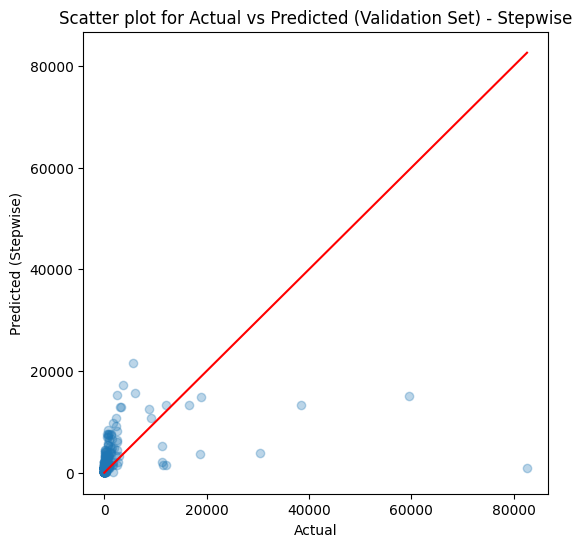

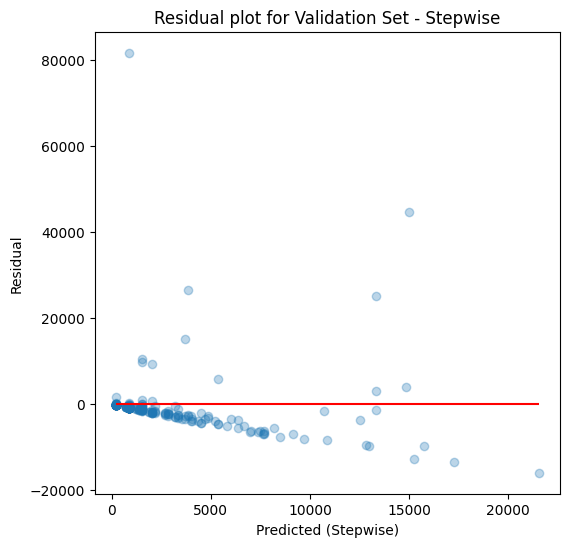

In [64]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define the function for forward stepwise selection
def forward_selection(data, response):
    """ Perform forward selection to select significant features for a regression model """
    initial_features = data.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(response, sm.add_constant(data[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < 0.05:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

# Load your data here
# Replace 'subset_regr_df' with your DataFrame
subset_regr_df_step = subset_regr_df.select_dtypes(include=[np.number])  # Ensure only numeric data

# Split the data into training and validation sets
cutoff_year_regr_step = 2015
train_df_step = subset_regr_df_step[subset_regr_df_step['year_cy'] < cutoff_year_regr_step]
validation_df_step = subset_regr_df_step[subset_regr_df_step['year_cy'] >= cutoff_year_regr_step]

# Further split the validation_df into validation and test sets (50-50 split)
validation_df_step, test_df_step = train_test_split(validation_df_step, test_size=0.5, random_state=42)

# Define features (X) and target (y) for training
x_train_step = train_df_step.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy'])
y_train_step = train_df_step['cumulative_total_deaths_in_orgvio_best_cy']

# Perform forward selection
selected_features_step = forward_selection(x_train_step, y_train_step)
print(f"Selected features: {selected_features_step}")

# Create the final model using selected features
final_model_step = sm.OLS(y_train_step, sm.add_constant(x_train_step[selected_features_step])).fit()

# Print the summary of the final model
print(final_model_step.summary())

# Define features (X) and target (y) for validation
x_validation_step = validation_df_step[selected_features_step]
y_validation_step = validation_df_step['cumulative_total_deaths_in_orgvio_best_cy']

# Make predictions on the training set
y_pred_train_step = final_model_step.predict(sm.add_constant(x_train_step[selected_features_step]))

# Evaluate the model on the training set
mse_train_step = mean_squared_error(y_train_step, y_pred_train_step)
rmse_train_step = np.sqrt(mse_train_step)
mae_train_step = mean_absolute_error(y_train_step, y_pred_train_step)
r2_train_step = r2_score(y_train_step, y_pred_train_step)

print(f"Training Mean Squared Error: {mse_train_step}")
print(f"Training Root Mean Squared Error: {rmse_train_step}")
print(f"Training Mean Absolute Error: {mae_train_step}")
print(f"Training R-squared: {r2_train_step}")

# Make predictions on the validation set
y_pred_validation_step = final_model_step.predict(sm.add_constant(x_validation_step))

# Evaluate the model on the validation set
mse_validation_step = mean_squared_error(y_validation_step, y_pred_validation_step)
rmse_validation_step = np.sqrt(mse_validation_step)
mae_validation_step = mean_absolute_error(y_validation_step, y_pred_validation_step)
r2_validation_step = r2_score(y_validation_step, y_pred_validation_step)

print(f"Validation Mean Squared Error: {mse_validation_step}")
print(f"Validation Root Mean Squared Error: {rmse_validation_step}")
print(f"Validation Mean Absolute Error: {mae_validation_step}")
print(f"Validation R-squared: {r2_validation_step}")

# Scatter plot: Actual vs Predicted values for the validation set
plt.figure(figsize=(6, 6))
plt.scatter(y_validation_step, y_pred_validation_step, alpha=0.3)
plt.plot([min(y_validation_step), max(y_validation_step)], [min(y_validation_step), max(y_validation_step)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted (Stepwise)')
plt.title('Scatter plot for Actual vs Predicted (Validation Set) - Stepwise')
plt.show()

# Residual plots for the validation set
residuals_validation_step = y_validation_step - y_pred_validation_step
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_validation_step, residuals_validation_step, alpha=0.3)
plt.hlines(0, min(y_pred_validation_step), max(y_pred_validation_step), colors='red')
plt.xlabel('Predicted (Stepwise)')
plt.ylabel('Residual')
plt.title('Residual plot for Validation Set - Stepwise')
plt.show()

# Create a DataFrame to compare actual and predicted values
comparison_df_validation_step = pd.DataFrame({
    'Actual': y_validation_step.values,
    'Predicted': y_pred_validation_step
})


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 1339.4487 - mean_absolute_error: 1339.4487
Mean Absolute Error on Training data: 1506.193115234375
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 1344.3126 - mean_absolute_error: 1344.3126
Mean Absolute Error on Training data (Hyperparameter Model): 1512.228759765625
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 1313.9387 - mean_absolute_error: 1313.9387
Mean Absolute Error on Test data (all years): 1643.508544921875
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 1316.5278 - mean_absolute_error: 1316.5278
Mean Absolute Error on Test data (all years) (Hyperparameter Model): 1652.7603759765625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1120.1337 - mean_absolute_error: 1120.1337
Mean Absolute Error on Test data (2015): 1120.1336669921875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1121.7788 - mean_absolute_error: 1121.7788
Mean Absolute Error on Test data (2015) (Hyperparameter Model): 1121.77880859375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15

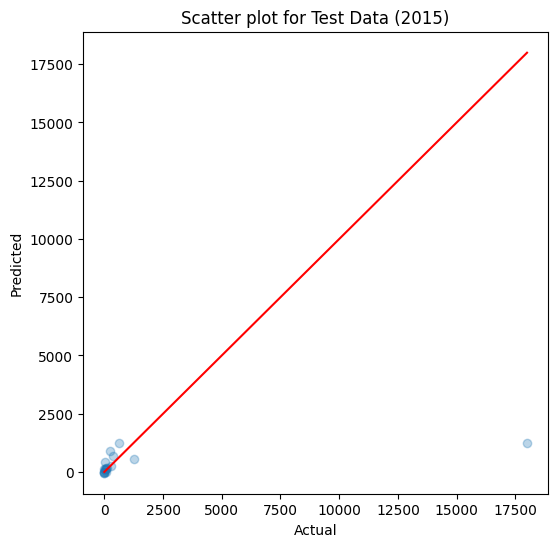

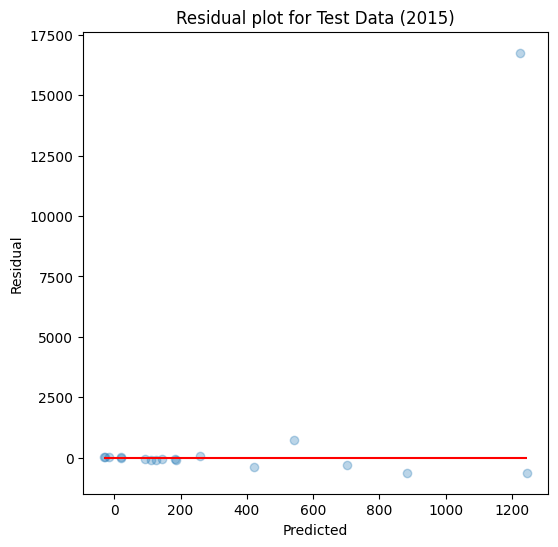

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


NameError: name 'test_mae_2015_hyptun' is not defined

In [71]:
##### Predict only 1 year with each model

cutoff_year_2 = 2015

# Split the data into training and initial validation
train_df_2 = subset_df[subset_df['year_cy'] < cutoff_year_2]
validation_df_2 = subset_df[subset_df['year_cy'] >= cutoff_year_2]

# Further split the validation_df into validation and test sets (50-50 split)
validation_df_2, test_df_2 = train_test_split(validation_df_2, test_size=0.5, random_state=42)

# Create a second subset of the test set that only contains data from 2015
test_df_2015 = test_df_2[test_df_2['year_cy'] == 2015]

# Define features (X) and targets (y) for training
x_train_2 = train_df_2.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_train_2 = train_df_2[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for validation
x_validation_2 = validation_df_2.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_validation_2 = validation_df_2[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for test
x_test_2 = test_df_2.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test_2 = test_df_2[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for test set containing only 2015 data
x_test_2015 = test_df_2015.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test_2015 = test_df_2015[['cumulative_total_deaths_in_orgvio_best_cy']]

# Evaluate the model on the training data
train_mae_2 = model_2.evaluate(x_train_2, y_train_2)[1]
print(f"Mean Absolute Error on Training data: {train_mae_2}")

# Evaluate hyptun model on training data
train_mae_hyptun = hyptun_model.evaluate(x_train_2, y_train_2)[1]
print(f"Mean Absolute Error on Training data (Hyperparameter Model): {train_mae_hyptun}")

# Evaluate the model on the test data (all years in test set)
test_mae_2 = model_2.evaluate(x_test_2, y_test_2)[1]
print(f"Mean Absolute Error on Test data (all years): {test_mae_2}")

# Evaluate hyptun model on test data (all years in test set)
test_mae_hyptun = hyptun_model.evaluate(x_test_2, y_test_2)[1]
print(f"Mean Absolute Error on Test data (all years) (Hyperparameter Model): {test_mae_hyptun}")

# Evaluate the model on the test data (only 2015)
test_mae_2015 = model_2.evaluate(x_test_2015, y_test_2015)[1]
print(f"Mean Absolute Error on Test data (2015): {test_mae_2015}")

# Evaluate the model on the test data (only 2015)
test_mae_hyptun = hyptun_model.evaluate(x_test_2015, y_test_2015)[1]
print(f"Mean Absolute Error on Test data (2015) (Hyperparameter Model): {test_mae_hyptun}")

# Make predictions on the test data (only 2015)
y_pred_2015 = model_2.predict(x_test_2015)

# Make predictions on the test data with hyperparameter tuned model (only 2015)
y_pred_2015_hyptun = hyptun_model.predict(x_test_2015)

# Calculate additional performance metrics for the test data (only 2015)
mse_2015 = mean_squared_error(y_test_2015, y_pred_2015)
rmse_2015 = np.sqrt(mse_2015)
r2_2015 = r2_score(y_test_2015, y_pred_2015)

# Calculate additional performance metrics for the test data with hyperparameter tuned model (only 2015)
mse_2015_hyptun = mean_squared_error(y_test_2015, y_pred_2015_hyptun)
rmse_2015_hyptun = np.sqrt(mse_2015_hyptun)
r2_2015_hyptun = r2_score(y_test_2015, y_pred_2015_hyptun)

print(f"Mean Squared Error (2015): {mse_2015}")
print(f"Root Mean Squared Error (2015): {rmse_2015}")
print(f"R-squared (2015): {r2_2015}")

print(f"Mean Squared Error (2015) (Hyperparameter Model): {mse_2015_hyptun}")
print(f"Root Mean Squared Error (2015) (Hyperparameter Model): {rmse_2015_hyptun}")
print(f"R-squared (2015) (Hyperparameter Model): {r2_2015_hyptun}")

# Plot scatter and residual plots for the test data (only 2015)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_2015, y_pred_2015, alpha=0.3)
plt.plot([min(y_test_2015.values), max(y_test_2015.values)], [min(y_test_2015.values), max(y_test_2015.values)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter plot for Test Data (2015)')
plt.show()

residuals_2015 = y_test_2015.values.flatten() - y_pred_2015.flatten()
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_2015, residuals_2015, alpha=0.3)
plt.hlines(0, min(y_pred_2015), max(y_pred_2015), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for Test Data (2015)')
plt.show()

# Plot the learning curves
#plt.figure(figsize=(12, 6))
#plt.plot(history_2.history['loss'])
#plt.plot(history_2.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()

# Flatten the predictions
y_pred_2015_flat = y_pred_2015.flatten()

# Flatten the predictions for the hyperparameter tuned model
y_pred_2015_flat_hyptun = y_pred_2015_hyptun.flatten()

# Construct the DataFrame for comparison
comparison_df_2015 = pd.DataFrame({
    'Actual_Best_Estimate': y_test_2015.iloc[:, 0],
    'Predicted_Best_Estimate': y_pred_2015_flat
})

# Construct the DataFrame for comparison for the hyperparameter tuned model
comparison_df_2015_hyptun = pd.DataFrame({
    'Actual_Best_Estimate': y_test_2015.iloc[:, 0],
    'Predicted_Best_Estimate': y_pred_2015_flat_hyptun
})

# Calculate metrics for training set
train_rmse_2 = np.sqrt(mean_squared_error(y_train_2, model_2.predict(x_train_2)))
train_r2_2 = r2_score(y_train_2, model_2.predict(x_train_2))

# Calculate metrics for training set of the hyperparameter tuned model
train_rmse_hyptun = np.sqrt(mean_squared_error(y_train_2, hyptun_model.predict(x_train_2)))
train_r2_hyptun = r2_score(y_train_2, hyptun_model.predict(x_train_2))

# Calculate metrics for test set (only 2015)
test_rmse_2015 = np.sqrt(mean_squared_error(y_test_2015, y_pred_2015))
test_r2_2015 = r2_score(y_test_2015, y_pred_2015)

# calculate metrics for test set (only 2015) of the hyperparameter tuned model
test_rmse_2015_hyptun = np.sqrt(mean_squared_error(y_test_2015, y_pred_2015_hyptun))
test_r2_2015_hyptun = r2_score(y_test_2015, y_pred_2015_hyptun)

# Create DataFrame for comparison
comparison_metrics_df_2015 = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_2, train_mae_2, train_r2_2],
    'Test (2015)': [test_rmse_2015, test_mae_2015, test_r2_2015]
})

# Create DataFrame for comparison for the hyperparameter tuned model
comparison_metrics_df_2015_hyptun = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_hyptun, train_mae_hyptun, train_r2_hyptun],
    'Test (2015)': [test_rmse_2015_hyptun, test_mae_2015_hyptun, test_r2_2015_hyptun]
})

print(comparison_metrics_df_2015)



In [38]:
### Same process for the lasso model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso

# Define the cutoff year for training and validation
cutoff_year_regr = 2015

# Split the data into training and initial validation
train_df_lasso = subset_regr_df[subset_regr_df['year_cy'] < cutoff_year_regr]
validation_df_lasso = subset_regr_df[subset_regr_df['year_cy'] >= cutoff_year_regr]

# Further split the validation_df into validation and test sets (50-50 split)
validation_df_lasso, test_df_lasso = train_test_split(validation_df_lasso, test_size=0.5, random_state=42)

# Create a second subset of the test set that only contains data from 2015
test_df_2015_lasso = test_df_lasso[test_df_lasso['year_cy'] == 2015]

# Define features (X) and targets (y) for training
x_train_lasso = train_df_lasso.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy'])
y_train_lasso = train_df_lasso[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for validation
x_validation_lasso = validation_df_lasso.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy'])
y_validation_lasso = validation_df_lasso[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for test
x_test_lasso = test_df_lasso.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy'])
y_test_lasso = test_df_lasso[['cumulative_total_deaths_in_orgvio_best_cy']]

# Define features (X) and targets (y) for test set containing only 2015 data
x_test_2015_lasso = test_df_2015_lasso.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy'])
y_test_2015_lasso = test_df_2015_lasso[['cumulative_total_deaths_in_orgvio_best_cy']]

# Create a Lasso regression model
lasso_model = Lasso(alpha=0.1) 

# Fit the model to the training data
lasso_model.fit(x_train_lasso, y_train_lasso)

# Make predictions on the training set
y_pred_train_lasso = lasso_model.predict(x_train_lasso)

# Set negative predictions to 0
y_pred_train_lasso[y_pred_train_lasso < 0] = 0

# Evaluate the model on the training set
mse_train_lasso = mean_squared_error(y_train_lasso, y_pred_train_lasso)
rmse_train_lasso = np.sqrt(mse_train_lasso)
mae_train_lasso = mean_absolute_error(y_train_lasso, y_pred_train_lasso)
r2_train_lasso = r2_score(y_train_lasso, y_pred_train_lasso)

print(f"Training Mean Squared Error (LASSO): {mse_train_lasso}")
print(f"Training Root Mean Squared Error (LASSO): {rmse_train_lasso}")
print(f"Training Mean Absolute Error (LASSO): {mae_train_lasso}")
print(f"Training R-squared (LASSO): {r2_train_lasso}")

# Make predictions on the test set (all years)
y_pred_test_lasso = lasso_model.predict(x_test_lasso)

# Set negative predictions to 0
y_pred_test_lasso[y_pred_test_lasso < 0] = 0

# Evaluate the model on the test set (all years)
mse_test_lasso = mean_squared_error(y_test_lasso, y_pred_test_lasso)
rmse_test_lasso = np.sqrt(mse_test_lasso)
mae_test_lasso = mean_absolute_error(y_test_lasso, y_pred_test_lasso)
r2_test_lasso = r2_score(y_test_lasso, y_pred_test_lasso)

print(f"Test Mean Squared Error (LASSO): {mse_test_lasso}")
print(f"Test Root Mean Squared Error (LASSO): {rmse_test_lasso}")
print(f"Test Mean Absolute Error (LASSO): {mae_test_lasso}")
print(f"Test R-squared (LASSO): {r2_test_lasso}")

# Make predictions on the test set (only 2015)
y_pred_test_2015_lasso = lasso_model.predict(x_test_2015_lasso)

# Set negative predictions to 0
y_pred_test_2015_lasso[y_pred_test_2015_lasso < 0] = 0

# Evaluate the model on the test set (only 2015)
mse_test_2015_lasso = mean_squared_error(y_test_2015_lasso, y_pred_test_2015_lasso)
rmse_test_2015_lasso = np.sqrt(mse_test_2015_lasso)
mae_test_2015_lasso = mean_absolute_error(y_test_2015_lasso, y_pred_test_2015_lasso)
r2_test_2015_lasso = r2_score(y_test_2015_lasso, y_pred_test_2015_lasso)

print(f"Test (2015) Mean Squared Error (LASSO): {mse_test_2015_lasso}")
print(f"Test (2015) Root Mean Squared Error (LASSO): {rmse_test_2015_lasso}")
print(f"Test (2015) Mean Absolute Error (LASSO): {mae_test_2015_lasso}")
print(f"Test (2015) R-squared (LASSO): {r2_test_2015_lasso}")

comparison_df_test_lasso = pd.DataFrame({
    'Actual': y_test_lasso.values.flatten(),
    'Predicted': y_pred_test_lasso.flatten()
})

comparison_df_test_2015_lasso = pd.DataFrame({
    'Actual': y_test_2015_lasso.values.flatten(),
    'Predicted': y_pred_test_2015_lasso.flatten()
})

Training Mean Squared Error (LASSO): 430318712.8367022
Training Root Mean Squared Error (LASSO): 20744.124778758494
Training Mean Absolute Error (LASSO): 2377.082830965396
Training R-squared (LASSO): 0.01705444620147134
Test Mean Squared Error (LASSO): 65616079.898866594
Test Root Mean Squared Error (LASSO): 8100.375293705014
Test Mean Absolute Error (LASSO): 2377.9349123258935
Test R-squared (LASSO): 0.08534030232702328
Test (2015) Mean Squared Error (LASSO): 9832668.339520067
Test (2015) Root Mean Squared Error (LASSO): 3135.7085865112
Test (2015) Mean Absolute Error (LASSO): 1007.8657311448753
Test (2015) R-squared (LASSO): 0.41185607847390093


In [116]:
# load hyperparameter tuned model
from tensorflow.keras.models import load_model

hyptun_model = load_model('hyperparameter_tuned_model.h5')

y_pred_validation_hyptun = hyptun_model.predict(x_validation_2)


# Ensure y_validation_2 and y_pred_validation_hyptun are 1-dimensional arrays
if isinstance(y_validation_2, pd.Series) or isinstance(y_validation_2, pd.DataFrame):
    y_validation_2 = y_validation_2.values
if isinstance(y_pred_validation_hyptun, pd.Series) or isinstance(y_pred_validation_hyptun, pd.DataFrame):
    y_pred_validation_hyptun = y_pred_validation_hyptun.values

    # Flatten if necessary
y_validation_2 = y_validation_2.flatten() if y_validation_2.ndim > 1 else y_validation_2
y_pred_validation_hyptun = y_pred_validation_hyptun.flatten() if y_pred_validation_hyptun.ndim > 1 else y_pred_validation_hyptun

# Calculate residuals
residuals_validation_hyptun = y_validation_2 - y_pred_validation_hyptun

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


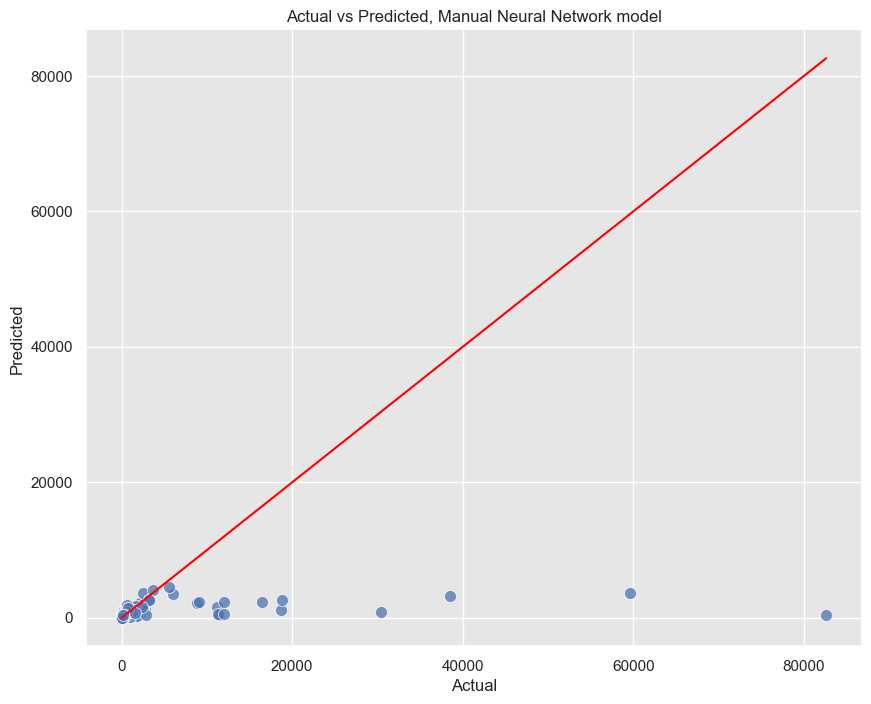

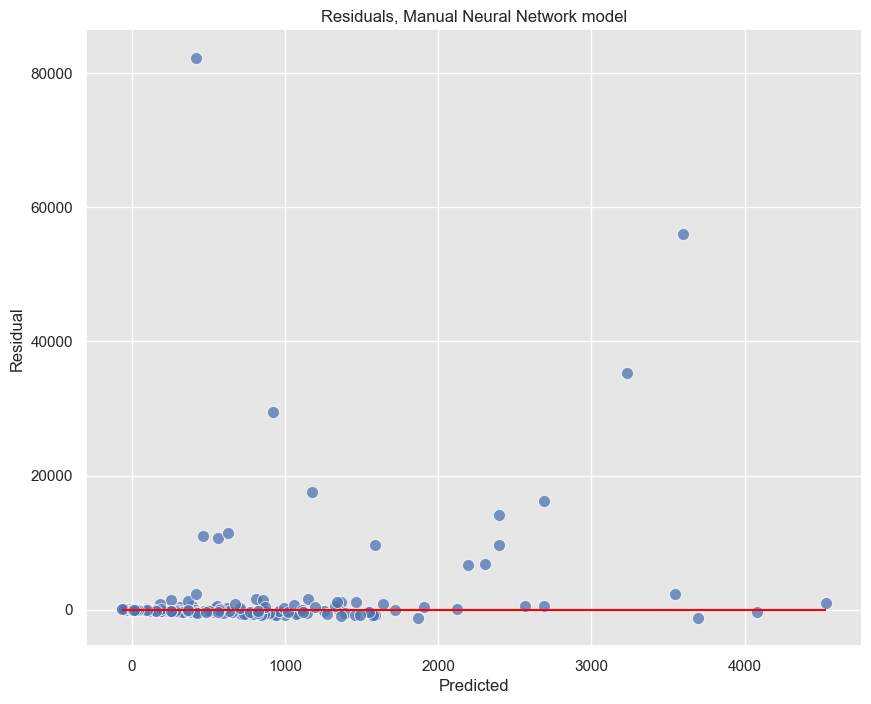

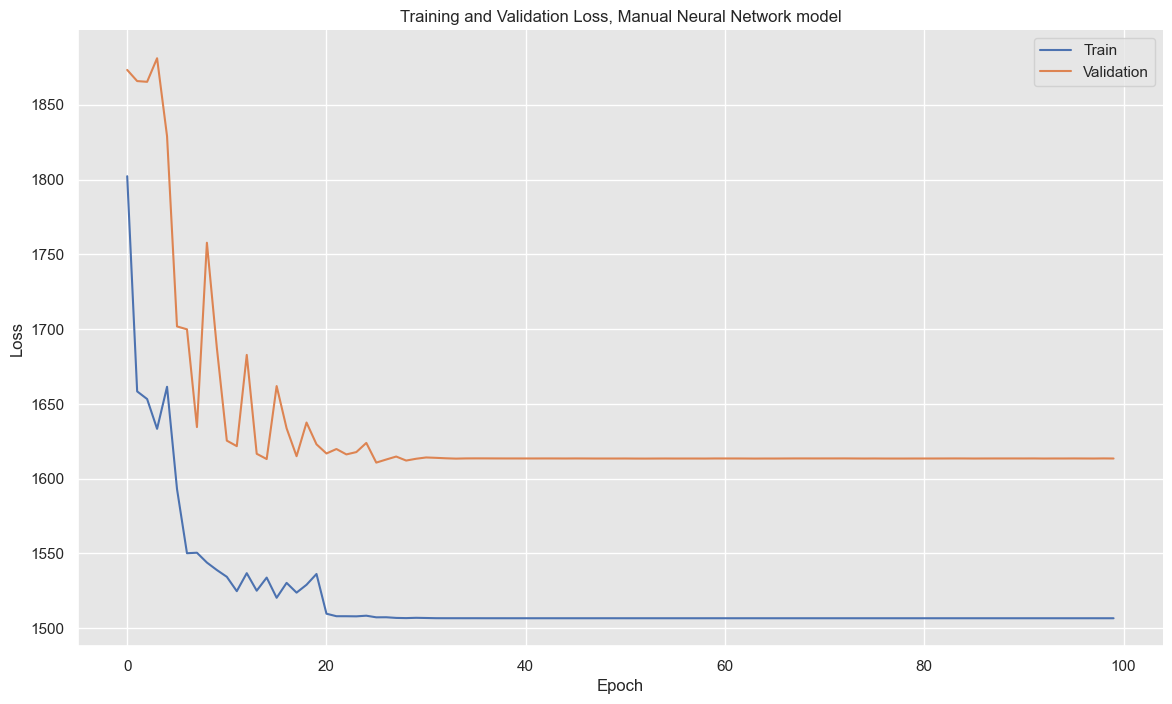

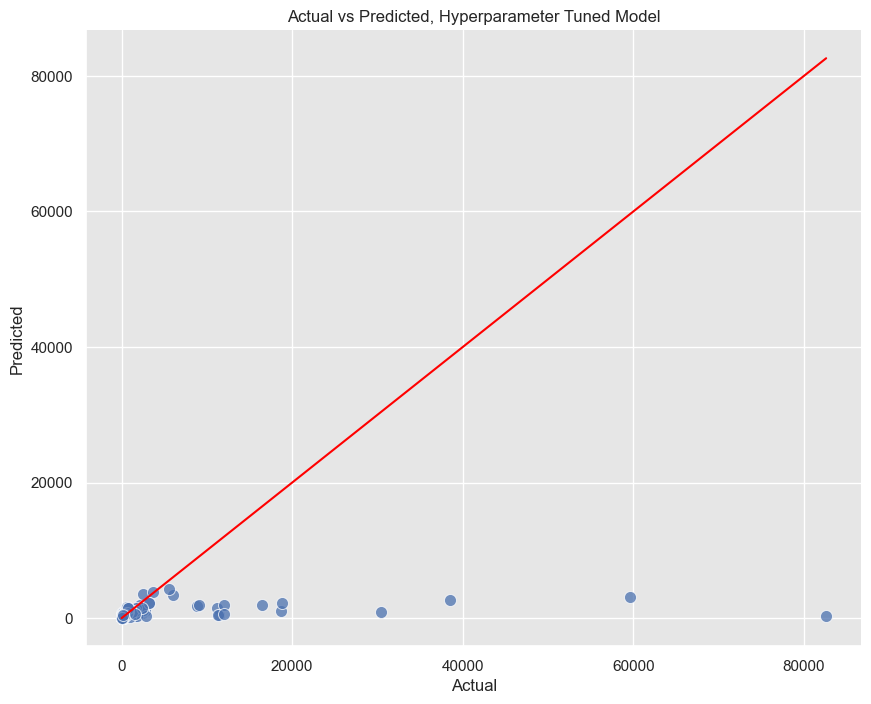

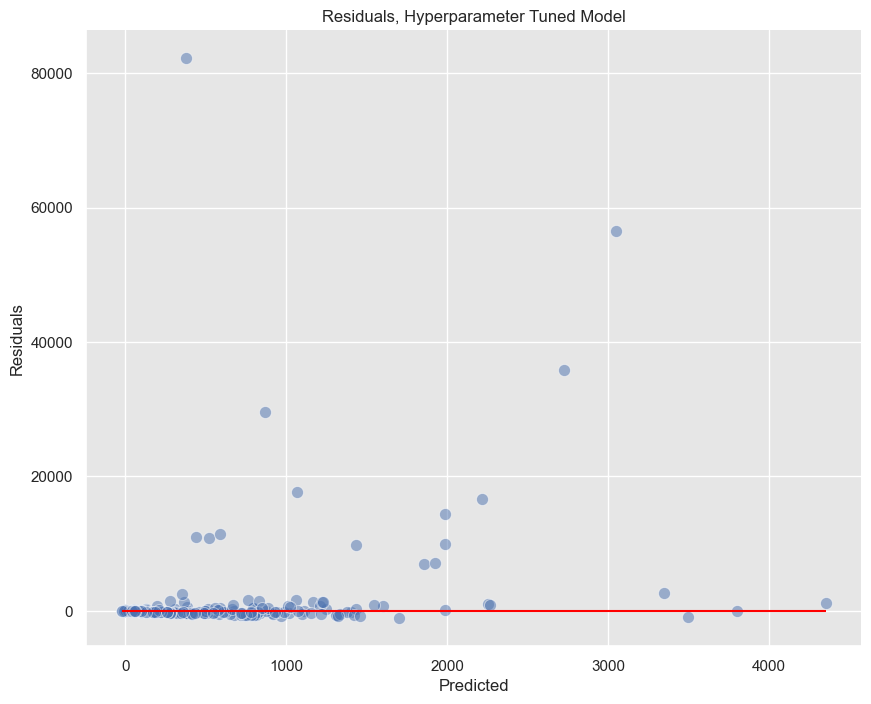

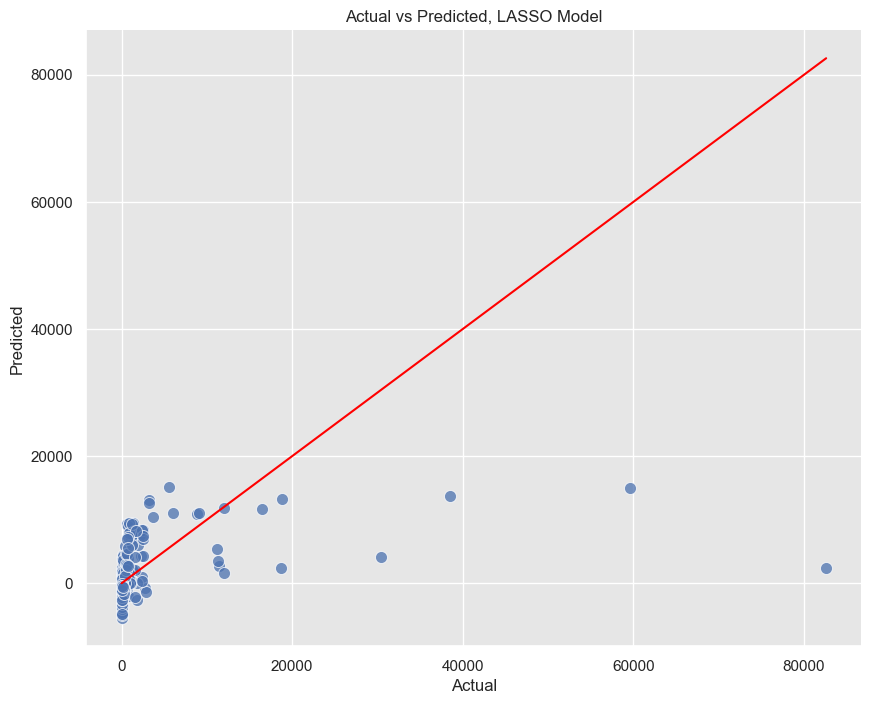

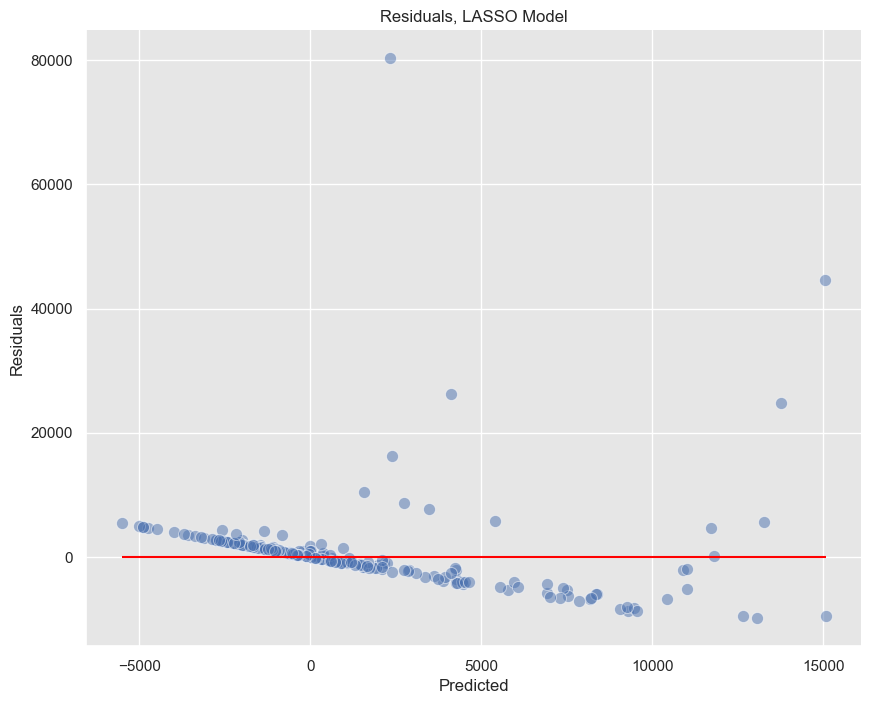

In [119]:
# Making graphs better looking:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.color_palette("pastel")

#############################################################################################################
##### Neural Network Manual model

# Actual vs predicted
# Ensure the inputs are 1-dimensional arrays or Series
if isinstance(y_validation_2, pd.DataFrame):
    y_validation_2_sns = y_validation_2.values.flatten()
else:
    y_validation_2_sns = y_validation_2.flatten() if len(y_validation_2.shape) > 1 else y_validation_2

if isinstance(y_pred_2, pd.DataFrame):
    y_pred_2_sns = y_pred_2.values.flatten()
else:
    y_pred_2_sns = y_pred_2.flatten() if len(y_pred_2.shape) > 1 else y_pred_2

residuals_2_sns = y_validation_2_sns - y_pred_2_sns
# Scatter plot: Actual vs Predicted values for the second model
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_validation_2_sns, y=y_pred_2_sns, alpha=0.75, s=75)
plt.plot([min(y_validation_2_sns), max(y_validation_2_sns)], [min(y_validation_2_sns), max(y_validation_2_sns)], color="Red")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted, Manual Neural Network model')
sns.despine()
plt.show()
# Predicted vs Residuals
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred_2_sns, y=residuals_2_sns, alpha=0.75, s =75)
plt.hlines(0, min(y_pred_2_sns), max(y_pred_2_sns), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residuals, Manual Neural Network model')
sns.despine()
plt.show()
# Loss function training vs validation
plt.figure(figsize=(14, 8))
sns.lineplot(x=range(len(history_2.history['loss'])), y=history_2.history['loss'], label='Train')
sns.lineplot(x=range(len(history_2.history['val_loss'])), y=history_2.history['val_loss'], label='Validation')
plt.title('Training and Validation Loss, Manual Neural Network model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
sns.despine()
plt.show()

#############################################################################################################
#### Neural Network Hyperparameter Tuned model
# Actual vs predicted
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_validation_2, y=y_pred_validation_hyptun, alpha=0.75, s=75)
plt.plot([min(y_validation_2), max(y_validation_2)], [min(y_validation_2), max(y_validation_2)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted, Hyperparameter Tuned Model')
sns.despine()
plt.show()
# Predicted vs Residuals
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred_validation_hyptun, y=residuals_validation_hyptun, alpha=0.5, s=75)
plt.hlines(0, min(y_pred_validation_hyptun), max(y_pred_validation_hyptun), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals, Hyperparameter Tuned Model')
sns.despine()
plt.show()



#############################################################################################################
#### LASSO Regression model
if isinstance(y_validation_lasso, pd.Series) or isinstance(y_validation_lasso, pd.DataFrame):
    y_validation_lasso = y_validation_lasso.values
if isinstance(y_pred_validation_lasso, pd.Series) or isinstance(y_pred_validation_lasso, pd.DataFrame):
    y_pred_validation_lasso = y_pred_validation_lasso.values

# Convert to numpy arrays if they are pandas Series/DataFrame
if isinstance(y_validation_lasso, pd.Series) or isinstance(y_validation_lasso, pd.DataFrame):
    y_validation_lasso = y_validation_lasso.values
if isinstance(y_pred_validation_lasso, pd.Series) or isinstance(y_pred_validation_lasso, pd.DataFrame):
    y_pred_validation_lasso = y_pred_validation_lasso.values

# Ensure the arrays are 1-dimensional
y_validation_lasso = y_validation_lasso.flatten() if y_validation_lasso.ndim > 1 else y_validation_lasso
y_pred_validation_lasso = y_pred_validation_lasso.flatten() if y_pred_validation_lasso.ndim > 1 else y_pred_validation_lasso

# Check if both arrays have the same length
if len(y_validation_lasso) != len(y_pred_validation_lasso):
    raise ValueError(f"Shape mismatch: y_validation_lasso has length {len(y_validation_lasso)}, but y_pred_validation_lasso has length {len(y_pred_validation_lasso)}")

# Calculate residuals
residuals_validation_lasso = y_validation_lasso - y_pred_validation_lasso


# Actual vs predicted
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_validation_lasso, y=y_pred_validation_lasso, alpha=0.75, s=75)
plt.plot([min(y_validation_lasso), max(y_validation_lasso)], [min(y_validation_lasso), max(y_validation_lasso)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted, LASSO Model')
sns.despine()
plt.show()

# Scatter plot: Predicted vs Residuals
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred_validation_lasso, y=residuals_validation_lasso, alpha=0.5, s=75)
plt.hlines(0, min(y_pred_validation_lasso), max(y_pred_validation_lasso), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals, LASSO Model')
sns.despine()
plt.show()

In [136]:

data = {
    "Model": ["Hand-tuned Neural Network", "Hyperparameter Neural Network", "LASSO Regression"],
    "Training MAE (1989-2014)": [1506, 1512, 2377],
    "Test MAE (2015-2022)": [1643, 1652, 2377],
    "Test MAE 2015 only": [1119, 1121, 1007]
}

final_result = pd.DataFrame(data)
print("DataFrame:")
print(final_result)
print()

DataFrame:
                           Model  Training MAE (1989-2014)  \
0      Hand-tuned Neural Network                      1506   
1  Hyperparameter Neural Network                      1512   
2               LASSO Regression                      2377   

   Test MAE (2015-2022)  Test MAE 2015 only  
0                  1643                1119  
1                  1652                1121  
2                  2377                1007  

